# Preliminaries

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

sys.path.append("/Users/paolo/Documents/methods/CMI_FS")
from feature_selection import forwardFeatureSelection

sys.path.append("/Users/paolo/Documents/methods/LinCFA")
from LinCFA import LinCFA

sys.path.append("/Users/paolo/Documents/methods/NonLinCFA")
from NonLinCFA import NonLinCFA

sys.path.append("/Users/paolo/Documents/Droughts/Paolo/regression_NonLinCFA")
from aux import standardize,unfold_dataset,compute_r2,prepare_target,prepare_features,aggregate_unfolded_data,aggregate_unfolded_data_onlyTrain,FS_with_linearWrapper,compare_methods, compute_r2


In [44]:
def plot_cells(output,selected_colnames):
    x = []
    y = []
    colors = cm.rainbow(np.linspace(0,1,len(output)))
    np.random.shuffle(colors)
    for i in range(len(output)): 
        #print(len(output[i]))
        x = []
        y = []
        
        for datum in output[i]:
            x.append(float(datum.split('_')[1]))
            y.append(float(datum.split('_')[2]))
        ax[0].scatter(x,y,color=colors[i],s=10)
        ax[0].set_title('8 days temperature aggregation')
    
    #x = []
    #y = []
    #col = cm.rainbow(np.linspace(0,1,len(selected_colnames)))
    #for i in range(len(selected_colnames)): 
    #    idx = int(selected_colnames[i].split('_')[-1])
    #    for datum in output[idx]:
    #        x.append(float(datum.split('_')[1]))
    #        y.append(float(datum.split('_')[2]))
    #    ax[1].scatter(x,y,color=col[i],s=10)
    

# Temperature, cross-val for epsilon

## NonLinCFA: wrapper and CMI FS

In [77]:
path_target = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/csv_VHI/'
basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona','Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']
path_features='/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/features/csv_allvalues/temporal_aggreg/'

val_res_wrapper = {}
val_res_wrapper_best5 = {}
val_res_CMI = {}
val_res_CMI_best5 = {}

best_epsilon_wrapper = 0
best_epsilon_wrapper_best5 = 0
best_epsilon_CMI = 0
best_epsilon_CMI_best5 = 0

best_valR2_wrapper = -100
best_valR2_wrapper_best5 = -100
best_valR2_CMI = -100
best_valR2_CMI_best5 = -100

for basin in basins:
    
    best_epsilon_wrapper = 0
    best_epsilon_wrapper_best5 = 0
    best_epsilon_CMI = 0
    best_epsilon_CMI_best5 = 0
    
    best_valR2_wrapper = -100
    best_valR2_wrapper_best5 = -100
    best_valR2_CMI = -100
    best_valR2_CMI_best5 = -100
    
    for eps in [0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]:
        print('####################' + basin + '_' + str(eps) + '####################')
        
        target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01', path=path_target+basin+'.csv')
        actual_path = path_features+basin+'_aggreg.csv'
        
        # uso solo il test per ottenere la dimensionality reduction
        output,aggregate_train,aggregate_val,aggregate_test = aggregate_unfolded_data_onlyTrain(actual_path,['cyclostationary_mean_tg', 
                                                                             'cyclostationary_mean_tg_1w',
                                                                             'cyclostationary_mean_tg_4w', 
                                                                             'cyclostationary_mean_tg_8w',
                                                                             'cyclostationary_mean_tg_12w', 
                                                                             'cyclostationary_mean_tg_16w',
                                                                             'cyclostationary_mean_tg_24w'
                                                                            ],
                                                                       target_df_train, target_df_val, eps=eps,
                                                                       max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')
        
        # uso la validation per scegliere epsilon e il numero di dati 
        aggregate_trainVal = pd.concat((aggregate_train,aggregate_val),axis=0)
        selected_colnames = FS_with_linearWrapper(aggregate_trainVal, target_df_train, target_df_val, min(50,aggregate_trainVal.shape[1]-1), 228)

        print('\nFull model and selected features with wrapper\n')
        fs_aggr_regr_score = compare_methods(aggregate_train, aggregate_val, target_df_train, target_df_val, selected_colnames)
        val_res_wrapper[basin + '_' + str(eps)] = fs_aggr_regr_score
        if round(fs_aggr_regr_score,4)>best_valR2_wrapper:
            best_valR2_wrapper = fs_aggr_regr_score
            best_epsilon_wrapper = str(eps)
        
        print('\nFull model and best 5 selected features with wrapper\n')
        fs_aggr_regr_score = compare_methods(aggregate_train, aggregate_val, target_df_train, target_df_val, selected_colnames[0:5])
        val_res_wrapper_best5[basin + '_' + str(eps)] = fs_aggr_regr_score
        if round(fs_aggr_regr_score,4)>best_valR2_wrapper_best5:
            best_valR2_wrapper_best5 = fs_aggr_regr_score
            best_epsilon_wrapper_best5 = str(eps)        
        
        
        ### CMI FS
        res = {
            "delta" : [], 
            "numSelected" : [], 
            "selectedFeatures" : [] 
        }
        
        res['selectedFeatures'] = forwardFeatureSelection(10,np.array(aggregate_train),np.array(target_df_train.mean_std),res,10,1)
        
        selectedFeatures='selectedFeatures'
        print(f'\n{res[selectedFeatures]}\n')
        selected_colnames = aggregate_train.columns[res['selectedFeatures']]
    
        print('\nFull model and selected features with CMI FS\n')
        fs_aggr_regr_score = compare_methods(aggregate_train, aggregate_val, target_df_train, target_df_val, selected_colnames)
        val_res_CMI[basin + '_' + str(eps)] = fs_aggr_regr_score
        if round(fs_aggr_regr_score,4)>best_valR2_CMI:
            best_valR2_CMI = fs_aggr_regr_score
            best_epsilon_CMI = str(eps)    
        
        print('\nFull model and best 5 selected features with CMI FS\n')
        fs_aggr_regr_score = compare_methods(aggregate_train, aggregate_val, target_df_train, target_df_val, selected_colnames[0:5])
        val_res_CMI_best5[basin + '_' + str(eps)] = fs_aggr_regr_score
        if round(fs_aggr_regr_score,4)>best_valR2_CMI_best5:
            best_valR2_CMI_best5 = fs_aggr_regr_score
            best_epsilon_CMI_best5 = str(eps)  
        
        print('\n\n\n')
    print(f'Best epsilons: {best_epsilon_wrapper,best_epsilon_wrapper_best5,best_epsilon_CMI,best_epsilon_CMI_best5}')
    print(f'Best R2: {best_valR2_wrapper,best_valR2_wrapper_best5,best_valR2_CMI,best_valR2_CMI_best5}')
    print('\n\n\n')
    
    val_res_wrapper[basin] = [best_epsilon_wrapper,best_valR2_wrapper]
    val_res_wrapper_best5[basin] = [best_epsilon_wrapper_best5,best_valR2_wrapper_best5]
    val_res_CMI[basin] = [best_epsilon_CMI,best_valR2_CMI]
    val_res_CMI_best5[basin] = [best_epsilon_CMI_best5,best_valR2_CMI_best5]
    

####################Adda_0.01####################
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.039373    0.00  2001     1 -2.546951
1    2001-01-13  0.380618    0.43  2001     2 -0.277191
2    2001-01-21  0.341985    0.38  2001     3 -0.534156
3    2001-01-29  0.322044    0.35  2001     5 -0.666789
4    2001-02-06  0.354954    0.40  2001     6 -0.447894
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.382706    0.40  2009    48 -0.263306
407  2009-12-05  0.409921    0.46  2009    49 -0.082282
408  2009-12-13  0.472087    0.53  2009    50  0.331204
409  2009-12-21  0.324728    0.00  2009    52 -0.648940
410  2009-12-29  0.086512    0.00  2009    53 -2.233412

[411 rows x 6 columns]
 target shapes: ((411, 6), (228, 6), (639, 6), (228, 6))
Number of features: 92

Number of aggregated features: 3

Number of features: 92

Number of aggregated features: 5

Number of features: 92

Number of aggregated features: 2

Number 

Number of features: 92

Number of aggregated features: 7

Number of features: 92

Number of aggregated features: 6

Number of features: 92

Number of aggregated features: 5

Number of features: 92

Number of aggregated features: 4

Number of features: 92

Number of aggregated features: 3

Number of features: 92

Number of aggregated features: 3

Number of features: 92

Number of aggregated features: 1



selected columns: ['cyclostationary_mean_tg_1w_1', 'cyclostationary_mean_tg_1w_4', 'cyclostationary_mean_tg_4w_4', 'cyclostationary_mean_tg_1w_0', 'cyclostationary_mean_tg_16w_1', 'cyclostationary_mean_tg_12w_1', 'cyclostationary_mean_tg_1w_3', 'cyclostationary_mean_tg_4w_0', 'cyclostationary_mean_tg_8w_1', 'cyclostationary_mean_tg_4w_3', 'cyclostationary_mean_tg_24w_0', 'cyclostationary_mean_tg_1w_5', 'cyclostationary_mean_tg_8w_2'], 

validation score: 0.26292673831196467, 

number of selected features: 13

Full model and selected features with wrapper

Full aggregate regression trai

Number of features: 92

Number of aggregated features: 7

Number of features: 92

Number of aggregated features: 6

Number of features: 92

Number of aggregated features: 5

Number of features: 92

Number of aggregated features: 4

Number of features: 92

Number of aggregated features: 3

Number of features: 92

Number of aggregated features: 3

Number of features: 92

Number of aggregated features: 1



selected columns: ['cyclostationary_mean_tg_1w_1', 'cyclostationary_mean_tg_1w_4', 'cyclostationary_mean_tg_4w_4', 'cyclostationary_mean_tg_1w_0', 'cyclostationary_mean_tg_16w_1', 'cyclostationary_mean_tg_12w_1', 'cyclostationary_mean_tg_1w_3', 'cyclostationary_mean_tg_4w_0', 'cyclostationary_mean_tg_8w_1', 'cyclostationary_mean_tg_4w_3', 'cyclostationary_mean_tg_24w_0', 'cyclostationary_mean_tg_1w_5', 'cyclostationary_mean_tg_8w_2'], 

validation score: 0.2629267383119649, 

number of selected features: 13

Full model and selected features with wrapper

Full aggregate regression train

Number of features: 44

Number of aggregated features: 1

Number of features: 44

Number of aggregated features: 1

Number of features: 44

Number of aggregated features: 1

Number of features: 44

Number of aggregated features: 1

Number of features: 44

Number of aggregated features: 1

Number of features: 44

Number of aggregated features: 1

Number of features: 44

Number of aggregated features: 1



selected columns: ['cyclostationary_mean_tg_1w_0', 'cyclostationary_mean_tg_4w_0'], 

validation score: 0.034346965798321194, 

number of selected features: 2

Full model and selected features with wrapper

Full aggregate regression train score: 0.08287455072617456, test score: -0.07173102511849883
Aggregate regression train score with FS: 0.026834788922469932, test score: 0.034346965798321305

Full model and best 5 selected features with wrapper

Full aggregate regression train score: 0.08287455072617456, test score: -0.07173102511849883
Aggregate regression train score with FS: 0.026

Number of features: 44

Number of aggregated features: 3

Number of features: 44

Number of aggregated features: 3

Number of features: 44

Number of aggregated features: 1

Number of features: 44

Number of aggregated features: 1

Number of features: 44

Number of aggregated features: 1

Number of features: 44

Number of aggregated features: 1

Number of features: 44

Number of aggregated features: 1



selected columns: ['cyclostationary_mean_tg_0', 'cyclostationary_mean_tg_1w_2', 'cyclostationary_mean_tg_4w_0', 'cyclostationary_mean_tg_12w_0', 'cyclostationary_mean_tg_8w_0'], 

validation score: 0.06182340133227504, 

number of selected features: 5

Full model and selected features with wrapper

Full aggregate regression train score: 0.09983474512288282, test score: -0.07037168010913364
Aggregate regression train score with FS: 0.05237946326154885, test score: 0.06182340133227515

Full model and best 5 selected features with wrapper

Full aggregate regression train score: 0.09983474

CMI: 0.02542311761324062
Highest CMI score: 0.0328736799085316
Adding original feature: 7
Highest CMI score: -0.008363371019205382

[2, 10, 7]


Full model and selected features with CMI FS

Full aggregate regression train score: 0.09983474512288282, test score: -0.07037168010913364
Aggregate regression train score with FS: 0.06863565094841617, test score: -0.039173430341011395

Full model and best 5 selected features with CMI FS

Full aggregate regression train score: 0.09983474512288282, test score: -0.07037168010913364
Aggregate regression train score with FS: 0.06863565094841617, test score: -0.039173430341011395




Best epsilons: ('0.001', '0.001', '0.001', '0.001')
Best R2: (0.06182340133227504, 0.06182340133227504, -0.039173430341011395, -0.039173430341011395)




####################Emiliani1_0.01####################
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.379890    0.50  2001     1 -0.382765
1    2001-01-13  0.482679    0.58 

Number of features: 172

Number of aggregated features: 19

Number of features: 172

Number of aggregated features: 15

Number of features: 172

Number of aggregated features: 8

Number of features: 172

Number of aggregated features: 10

Number of features: 172

Number of aggregated features: 9

Number of features: 172

Number of aggregated features: 13

Number of features: 172

Number of aggregated features: 5



selected columns: ['cyclostationary_mean_tg_1w_12', 'cyclostationary_mean_tg_1w_7', 'cyclostationary_mean_tg_1w_9', 'cyclostationary_mean_tg_1w_10', 'cyclostationary_mean_tg_1w_14', 'cyclostationary_mean_tg_1w_4', 'cyclostationary_mean_tg_12w_8', 'cyclostationary_mean_tg_12w_6', 'cyclostationary_mean_tg_16w_3', 'cyclostationary_mean_tg_1w_2', 'cyclostationary_mean_tg_16w_7', 'cyclostationary_mean_tg_16w_10', 'cyclostationary_mean_tg_8w_6', 'cyclostationary_mean_tg_1w_11', 'cyclostationary_mean_tg_16w_2', 'cyclostationary_mean_tg_16w_11', 'cyclostationary_mean_tg_4w_6', 'cycl

Number of features: 172

Number of aggregated features: 20

Number of features: 172

Number of aggregated features: 16

Number of features: 172

Number of aggregated features: 9

Number of features: 172

Number of aggregated features: 11

Number of features: 172

Number of aggregated features: 9

Number of features: 172

Number of aggregated features: 13

Number of features: 172

Number of aggregated features: 5



selected columns: ['cyclostationary_mean_tg_1w_12', 'cyclostationary_mean_tg_1w_7', 'cyclostationary_mean_tg_1w_9', 'cyclostationary_mean_tg_1w_10', 'cyclostationary_mean_tg_1w_15', 'cyclostationary_mean_tg_1w_4', 'cyclostationary_mean_tg_12w_8', 'cyclostationary_mean_tg_12w_6', 'cyclostationary_mean_tg_16w_3', 'cyclostationary_mean_tg_1w_2', 'cyclostationary_mean_tg_16w_7', 'cyclostationary_mean_tg_16w_10', 'cyclostationary_mean_tg_8w_6', 'cyclostationary_mean_tg_1w_11', 'cyclostationary_mean_tg_16w_2', 'cyclostationary_mean_tg_16w_11', 'cyclostationary_mean_tg_4w_7', 'cycl

Highest CMI score: -1.2764826082284353e-05

[9, 72, 15, 81, 2, 8, 0, 19, 11]


Full model and selected features with CMI FS

Full aggregate regression train score: 0.5954074592640848, test score: -0.29127959038784046
Aggregate regression train score with FS: 0.2647758156981751, test score: 0.07828694833340877

Full model and best 5 selected features with CMI FS

Full aggregate regression train score: 0.5954074592640848, test score: -0.29127959038784046
Aggregate regression train score with FS: 0.22698425006634448, test score: 0.09182363515459357




####################Emiliani1_1e-05####################
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.379890    0.50  2001     1 -0.382765
1    2001-01-13  0.482679    0.58  2001     2  0.319215
2    2001-01-21  0.516259    0.59  2001     3  0.548542
3    2001-01-29  0.434421    0.50  2001     5 -0.010351
4    2001-02-06  0.494805    0.54  2001     6  0.402030
..          ...       ...     ...   

CMI: 0.006374905890354915
CMI: 0.009351492614650458
CMI: 0.007901557763829864
CMI: 0.0037757786801695947
CMI: 0.0018778206880314952
CMI: 0.001059469363158566
CMI: 0.004482652522661529
CMI: 0.0037244399478368606
CMI: 0.018805861909660243
CMI: 0.015449865265309337
Highest CMI score: 0.018805861909660243
Adding original feature: 81
CMI: 0.011104674071066023
CMI: 0.0016020191695461927
CMI: 0.005068202095798974
CMI: 0.005533625816115967
CMI: 0.008044744280762989
CMI: 0.00493585863777582
CMI: 0.010130451416689529
CMI: 0.00015259802096120878
CMI: 0.0029751841643526067
CMI: 0.005425315476104142
CMI: 0.007830713264036837
CMI: 0.002778503545409483
CMI: 0.00046121473622451337
CMI: 0.005478441402853196
CMI: 0.01094869761543929
CMI: 0.006066861407747898
CMI: 0.0034057073304702146
CMI: 0.0013972786623797084
Highest CMI score: 0.011104674071066023
Adding original feature: 2
CMI: 0.0010395320591728707
CMI: 0.0030450511515185963
CMI: 0.0007782306081852708
Highest CMI score: 0.0030450511515185963
Adding

CMI: 0.01971574328338252
CMI: 0.012160512144686247
CMI: 0.017601762808697907
CMI: 0.04824025933434356
CMI: 0.00797959465604206
CMI: 0.014950750030841758
CMI: 0.03606622001414586
CMI: 0.025193809813156914
CMI: 0.013334102574314416
CMI: 0.017557871883724596
CMI: 0.017236344047351554
CMI: 0.0200302288874048
CMI: 0.03198598133082395
CMI: 0.03735776569787422
CMI: 0.006238680045092898
CMI: 0.020211095687699493
CMI: 0.045723170237056215
CMI: 0.0024997036920081095
CMI: 0.023008373177907798
CMI: 0.0017753429418802813
CMI: 0.04174818466498528
CMI: 0.007347612216217825
CMI: 0.006419793566713489
CMI: 0.02978464378581991
CMI: 0.042543948570572976
CMI: 0.008819086568726986
CMI: 0.024098464427017796
CMI: 0.003926656295879821
CMI: 0.024788632037508945
CMI: 0.02231805293263786
CMI: 0.01903988252322214
CMI: 0.03414866974685968
CMI: 0.02213991501661189
CMI: 0.007111389455960404
CMI: 0.008064114478550627
CMI: 0.04362712631692353
CMI: 0.006127189675641104
CMI: 0.0006249021250607778
CMI: 0.00575466134470140

CMI: 0.013034066943946002
CMI: 0.04102958601025297
CMI: 0.009235911430730104
CMI: 0.02780859885464461
CMI: 0.0024441226136059785
CMI: 0.0012443904661200572
CMI: 0.0021939391826541615
CMI: 0.011761928734809815
CMI: 0.005374988473989775
CMI: 0.014540018180478217
CMI: 0.03252804731535902
CMI: 0.02063667286775696
CMI: 0.007107538898722038
CMI: 0.01568850666178853
CMI: 0.0012322059190685436
CMI: 0.01360869243967329
CMI: 0.009418118388650656
CMI: 0.010415262312756107
CMI: 0.026568948328221015
CMI: 0.00576583550726982
CMI: 0.0014257260117579162
CMI: 0.01136077279202223
CMI: 0.013950507925696423
CMI: 0.0002527562830688529
CMI: 0.029133643871538453
CMI: 0.012271779653259124
CMI: 0.003870008351102572
CMI: 0.0067867883443542
CMI: 0.019643696403683228
CMI: 0.013628374406073174
CMI: 0.017059763482682053
CMI: 0.025901382185791758
CMI: 0.009683204644375887
CMI: 0.02466751358851052
CMI: 0.0471966989366385
CMI: 0.020733669996426604
CMI: 0.028743726903736055
CMI: 0.02666641046413
CMI: 0.0175825200210067

Number of features: 130

Number of aggregated features: 4

Number of features: 130

Number of aggregated features: 5

Number of features: 130

Number of aggregated features: 3

Number of features: 130

Number of aggregated features: 1

Number of features: 130

Number of aggregated features: 2

Number of features: 130

Number of aggregated features: 1

Number of features: 130

Number of aggregated features: 1



selected columns: ['cyclostationary_mean_tg_1w_3', 'cyclostationary_mean_tg_1w_2', 'cyclostationary_mean_tg_4w_2', 'cyclostationary_mean_tg_1w_4', 'cyclostationary_mean_tg_4w_0', 'cyclostationary_mean_tg_4w_1', 'cyclostationary_mean_tg_24w_0', 'cyclostationary_mean_tg_12w_1'], 

validation score: 0.24301554747145504, 

number of selected features: 8

Full model and selected features with wrapper

Full aggregate regression train score: 0.2073621335965823, test score: 0.12115329615434622
Aggregate regression train score with FS: 0.1325073233459001, test score: 0.24301554747145504


CMI: 0.0009415327575210269
CMI: 0.01032621353028515
CMI: 0.014087164679759498
CMI: 0.0010439482107543752
Highest CMI score: 0.021661828244725914
Adding original feature: 3
CMI: 0.00641521703438333
CMI: 0.008897947640074191
CMI: 4.06533808278986e-05
Highest CMI score: 0.008897947640074191
Adding original feature: 12
CMI: 0.007040298885555643
Highest CMI score: 0.007040298885555643
Adding original feature: 2
Highest CMI score: -0.0005890779040526595

[1, 3, 12, 2]


Full model and selected features with CMI FS

Full aggregate regression train score: 0.21087499531626241, test score: 0.12198220945455751
Aggregate regression train score with FS: 0.14433771869230916, test score: 0.15173712714174004

Full model and best 5 selected features with CMI FS

Full aggregate regression train score: 0.21087499531626241, test score: 0.12198220945455751
Aggregate regression train score with FS: 0.14433771869230916, test score: 0.15173712714174004




####################Emiliani2_1e-06##################

Number of features: 67

Number of aggregated features: 1

Number of features: 67

Number of aggregated features: 2

Number of features: 67

Number of aggregated features: 1

Number of features: 67

Number of aggregated features: 1

Number of features: 67

Number of aggregated features: 1

Number of features: 67

Number of aggregated features: 1

Number of features: 67

Number of aggregated features: 1



selected columns: ['cyclostationary_mean_tg_1w_0', 'cyclostationary_mean_tg_1w_1', 'cyclostationary_mean_tg_4w_0', 'cyclostationary_mean_tg_8w_0'], 

validation score: -0.11196174349753751, 

number of selected features: 4

Full model and selected features with wrapper

Full aggregate regression train score: 0.11991567181390694, test score: -0.2458965296718878
Aggregate regression train score with FS: 0.049816166746506685, test score: -0.11196174349753751

Full model and best 5 selected features with wrapper

Full aggregate regression train score: 0.11991567181390694, test score: -0.24

Number of features: 67

Number of aggregated features: 1

Number of features: 67

Number of aggregated features: 3

Number of features: 67

Number of aggregated features: 2

Number of features: 67

Number of aggregated features: 1

Number of features: 67

Number of aggregated features: 1

Number of features: 67

Number of aggregated features: 1

Number of features: 67

Number of aggregated features: 1



selected columns: ['cyclostationary_mean_tg_1w_2', 'cyclostationary_mean_tg_4w_0', 'cyclostationary_mean_tg_8w_0'], 

validation score: -0.10466632894973538, 

number of selected features: 3

Full model and selected features with wrapper

Full aggregate regression train score: 0.13407855571790994, test score: -0.23383663678911049
Aggregate regression train score with FS: 0.04513858967256734, test score: -0.10466632894973493

Full model and best 5 selected features with wrapper

Full aggregate regression train score: 0.13407855571790994, test score: -0.23383663678911049
Aggregate regres

Number of features: 55

Number of aggregated features: 3

Number of features: 55

Number of aggregated features: 3

Number of features: 55

Number of aggregated features: 3

Number of features: 55

Number of aggregated features: 4

Number of features: 55

Number of aggregated features: 3

Number of features: 55

Number of aggregated features: 2

Number of features: 55

Number of aggregated features: 1



selected columns: ['cyclostationary_mean_tg_1w_1', 'cyclostationary_mean_tg_1w_2', 'cyclostationary_mean_tg_16w_1', 'cyclostationary_mean_tg_16w_0', 'cyclostationary_mean_tg_12w_1', 'cyclostationary_mean_tg_1w_0'], 

validation score: 0.373379708121908, 

number of selected features: 6

Full model and selected features with wrapper

Full aggregate regression train score: 0.28241613465792315, test score: 0.18994502778774103
Aggregate regression train score with FS: 0.15850918073327824, test score: 0.37337970812190735

Full model and best 5 selected features with wrapper

Full aggregate 

Number of features: 55

Number of aggregated features: 4

Number of features: 55

Number of aggregated features: 4

Number of features: 55

Number of aggregated features: 4

Number of features: 55

Number of aggregated features: 8

Number of features: 55

Number of aggregated features: 6

Number of features: 55

Number of aggregated features: 3

Number of features: 55

Number of aggregated features: 1



selected columns: ['cyclostationary_mean_tg_1w_1', 'cyclostationary_mean_tg_1w_3', 'cyclostationary_mean_tg_1w_2', 'cyclostationary_mean_tg_16w_1', 'cyclostationary_mean_tg_16w_0', 'cyclostationary_mean_tg_8w_1', 'cyclostationary_mean_tg_8w_2', 'cyclostationary_mean_tg_12w_3', 'cyclostationary_mean_tg_12w_0', 'cyclostationary_mean_tg_1w_0'], 

validation score: 0.37593026697473486, 

number of selected features: 10

Full model and selected features with wrapper

Full aggregate regression train score: 0.3377202230682491, test score: 0.07702417148535534
Aggregate regression train score w

Number of features: 55

Number of aggregated features: 5

Number of features: 55

Number of aggregated features: 4

Number of features: 55

Number of aggregated features: 5

Number of features: 55

Number of aggregated features: 8

Number of features: 55

Number of aggregated features: 6

Number of features: 55

Number of aggregated features: 3

Number of features: 55

Number of aggregated features: 1



selected columns: ['cyclostationary_mean_tg_1w_1', 'cyclostationary_mean_tg_1w_3', 'cyclostationary_mean_tg_1w_2', 'cyclostationary_mean_tg_16w_1', 'cyclostationary_mean_tg_16w_0', 'cyclostationary_mean_tg_8w_1', 'cyclostationary_mean_tg_8w_2', 'cyclostationary_mean_tg_12w_3', 'cyclostationary_mean_tg_12w_0', 'cyclostationary_mean_tg_1w_0'], 

validation score: 0.375930266974735, 

number of selected features: 10

Full model and selected features with wrapper

Full aggregate regression train score: 0.3392623236157323, test score: 0.07554166213083269
Aggregate regression train score wit

Number of features: 74

Number of aggregated features: 2

Number of features: 74

Number of aggregated features: 2

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1



selected columns: ['cyclostationary_mean_tg_1w_1', 'cyclostationary_mean_tg_1w_0', 'cyclostationary_mean_tg_8w_0', 'cyclostationary_mean_tg_4w_0'], 

validation score: 0.18646826287648188, 

number of selected features: 4

Full model and selected features with wrapper

Full aggregate regression train score: 0.13159669141947672, test score: 0.08802975469140739
Aggregate regression train score with FS: 0.06564769115720082, test score: 0.18646826287648144

Full model and best 5 selected features with wrapper

Full aggregate regression train score: 0.13159669141947672, test score: 0.088029

Number of features: 74

Number of aggregated features: 3

Number of features: 74

Number of aggregated features: 3

Number of features: 74

Number of aggregated features: 2

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1



selected columns: ['cyclostationary_mean_tg_1w_2', 'cyclostationary_mean_tg_1w_0', 'cyclostationary_mean_tg_8w_0', 'cyclostationary_mean_tg_4w_0'], 

validation score: 0.17379645258814813, 

number of selected features: 4

Full model and selected features with wrapper

Full aggregate regression train score: 0.13408946852584025, test score: 0.06823686856070421
Aggregate regression train score with FS: 0.05750778679836044, test score: 0.17379645258814835

Full model and best 5 selected features with wrapper

Full aggregate regression train score: 0.13408946852584025, test score: 0.068236

Number of features: 89

Number of aggregated features: 1

Number of features: 89

Number of aggregated features: 1

Number of features: 89

Number of aggregated features: 1

Number of features: 89

Number of aggregated features: 1

Number of features: 89

Number of aggregated features: 1

Number of features: 89

Number of aggregated features: 2

Number of features: 89

Number of aggregated features: 3



selected columns: ['cyclostationary_mean_tg_1w_0', 'cyclostationary_mean_tg_4w_0', 'cyclostationary_mean_tg_24w_1', 'cyclostationary_mean_tg_16w_1'], 

validation score: 0.11583967093335568, 

number of selected features: 4

Full model and selected features with wrapper

Full aggregate regression train score: 0.19556176719252327, test score: -0.07356329548782603
Aggregate regression train score with FS: 0.05591623396519385, test score: 0.11583967093335568

Full model and best 5 selected features with wrapper

Full aggregate regression train score: 0.19556176719252327, test score: -0.07

----- MI Scores -----
[(3, 0.09385889683189404), (2, 0.07955469104459592), (0, 0.07599912475153893), (1, 0.07138969828143861), (7, 0.0606835707948273), (22, 0.05296060047484302), (23, 0.050615416651295604), (21, 0.04989898243461806), (6, 0.04926527694951129), (5, 0.0486070783251582), (4, 0.041565559289788355), (19, 0.03935653220692416), (12, 0.037693879687650214), (17, 0.03707119846308733), (24, 0.03448765248252744), (18, 0.031889782312314444), (10, 0.027651359134344966), (20, 0.026914578390988105), (15, 0.024614911862723108), (13, 0.024027643891850362), (14, 0.022831600232934162), (16, 0.021358432862565963), (11, 0.01227597508618799), (9, 0.012063637764163223), (8, 0.005654268918101509)]
Best MI score: 0.09385889683189404
Adding first best original feature: 3
CMI: 0.0063110616251866175
CMI: 0.018969853723959762
CMI: 0.00041023569436431095
CMI: 0.004453163878129052
CMI: 0.004982949393528488
CMI: 0.004300444119331254
CMI: 0.00854361621613152
CMI: 0.014239691214050457
CMI: 0.022653634161

----- MI Scores -----
[(3, 0.09385889683189404), (2, 0.07955469104459592), (0, 0.07648156056409096), (1, 0.07421189335092186), (7, 0.0606835707948273), (22, 0.05296060047484302), (23, 0.050615416651295604), (21, 0.04989898243461806), (6, 0.04926527694951129), (5, 0.0486070783251582), (4, 0.041565559289788355), (19, 0.03935653220692416), (12, 0.037693879687650214), (17, 0.03707119846308733), (24, 0.03448765248252744), (18, 0.031889782312314444), (10, 0.027651359134344966), (20, 0.026914578390988105), (15, 0.024614911862723108), (13, 0.024027643891850362), (14, 0.022831600232934162), (16, 0.021358432862565963), (11, 0.01227597508618799), (9, 0.012063637764163223), (8, 0.005654268918101509)]
Best MI score: 0.09385889683189404
Adding first best original feature: 3
CMI: 0.0063110616251866175
CMI: 0.018969853723959762
CMI: 0.00041023569436431095
CMI: 0.004453163878129052
CMI: 0.004982949393528488
CMI: 0.004300444119331254
CMI: 0.00854361621613152
CMI: 0.014239691214050457
CMI: 0.022653634161

CMI: 0.009651451717362439
CMI: 0.008399053726424285
CMI: 0.011726910082325182
CMI: 0.02840377079129866
Highest CMI score: 0.02840377079129866
Adding original feature: 16
CMI: 0.012204458519703976
CMI: 0.0020109606772953648
CMI: 0.0025191468053630955
CMI: 0.02565666309654309
CMI: 0.03527967934183175
CMI: 0.03040828550433715
CMI: 0.035572866673259165
CMI: 0.0261770668436241
CMI: 0.040133241852603654
CMI: 0.014095287077767402
Highest CMI score: 0.040133241852603654
Adding original feature: 12
Highest CMI score: -0.0027284232078202686

[0, 16, 12]


Full model and selected features with CMI FS

Full aggregate regression train score: 0.1395593352745732, test score: -0.1788640039159135
Aggregate regression train score with FS: 0.09512166730910299, test score: -0.04495228440247878

Full model and best 5 selected features with CMI FS

Full aggregate regression train score: 0.1395593352745732, test score: -0.1788640039159135
Aggregate regression train score with FS: 0.09512166730910299, test sc

CMI: 0.0064781081094750365
CMI: 0.01708937262538844
CMI: 0.00770180341038211
CMI: 0.017903233860744633
CMI: 0.011305864445845012
CMI: 0.03168644724653612
Highest CMI score: 0.03168644724653612
Adding original feature: 18
CMI: 0.006404909906857659
CMI: 0.007368880559387156
CMI: 0.015057829624283009
CMI: 0.0251136235566925
CMI: 0.01976041312079445
CMI: 0.014217344291902606
CMI: 0.030059591203715347
CMI: 0.029137558416444526
CMI: 0.0318367759296507
CMI: 0.006910453970317462
CMI: 0.00706564091828589
Highest CMI score: 0.0318367759296507
Adding original feature: 14
CMI: 0.0010403287616601864
CMI: 0.0009698259292614253
Highest CMI score: 0.0010403287616601864
Adding original feature: 13
Highest CMI score: -0.0028626826333232325

[0, 18, 14, 13]


Full model and selected features with CMI FS

Full aggregate regression train score: 0.14607920272615893, test score: 0.011931397858032322
Aggregate regression train score with FS: 0.09973505441923125, test score: -0.1072030546461904

Full model and

Highest CMI score: -0.002853192569777341

[0, 19, 15, 14]


Full model and selected features with CMI FS

Full aggregate regression train score: 0.15033994018835417, test score: 0.018379425647369163
Aggregate regression train score with FS: 0.09973505441923125, test score: -0.10720305464619084

Full model and best 5 selected features with CMI FS

Full aggregate regression train score: 0.15033994018835417, test score: 0.018379425647369163
Aggregate regression train score with FS: 0.09973505441923125, test score: -0.10720305464619084




####################Piemonte_Sud_1e-07####################
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.278060    0.09  2001     1 -0.967137
1    2001-01-13  0.445159    0.48  2001     2  0.070382
2    2001-01-21  0.488982    0.52  2001     3  0.342478
3    2001-01-29  0.362487    0.37  2001     5 -0.442927
4    2001-02-06  0.430732    0.45  2001     6 -0.019192
..          ...       ...     ...   ...   ...  

Number of features: 92

Number of aggregated features: 3

Number of features: 92

Number of aggregated features: 5

Number of features: 92

Number of aggregated features: 3

Number of features: 92

Number of aggregated features: 3

Number of features: 92

Number of aggregated features: 3

Number of features: 92

Number of aggregated features: 3

Number of features: 92

Number of aggregated features: 4



selected columns: ['cyclostationary_mean_tg_1w_4', 'cyclostationary_mean_tg_1w_1', 'cyclostationary_mean_tg_16w_2', 'cyclostationary_mean_tg_12w_2', 'cyclostationary_mean_tg_1w_2', 'cyclostationary_mean_tg_12w_1', 'cyclostationary_mean_tg_16w_1', 'cyclostationary_mean_tg_8w_2', 'cyclostationary_mean_tg_4w_2', 'cyclostationary_mean_tg_24w_1', 'cyclostationary_mean_tg_24w_0', 'cyclostationary_mean_tg_16w_0', 'cyclostationary_mean_tg_12w_0'], 

validation score: 0.3456245138187063, 

number of selected features: 13

Full model and selected features with wrapper

Full aggregate regression 

----- MI Scores -----
[(1, 0.11452947376389895), (2, 0.08145983976669328), (0, 0.07690903518550618), (3, 0.07434499594269436), (4, 0.06870147995748536), (8, 0.057943668218813756), (11, 0.052341346141098886), (9, 0.04678501040010578), (22, 0.04504807640654216), (7, 0.03780031727306315), (6, 0.030992895426503207), (21, 0.027020191876226514), (19, 0.026814488745935675), (10, 0.02649432447696658), (5, 0.0263075713690637), (20, 0.026129990832795116), (12, 0.022019021713446125), (13, 0.01771694652196607), (18, 0.017088116714804508), (25, 0.016297156492754098), (15, 0.016153444708471097), (23, 0.013341684070698018), (14, 0.0003838826408639383), (24, 0.00030387603518602924), (16, -0.005573629766717583), (17, -0.021638291470429682)]
Best MI score: 0.11452947376389895
Adding first best original feature: 1
Highest CMI score: -0.0008511803399993134

[1]


Full model and selected features with CMI FS

Full aggregate regression train score: 0.2757314824234447, test score: 0.0142053825131363
Aggregat

In [78]:
val_res_wrapper

{'Adda_0.01': 0.23372745943443896,
 'Adda_0.001': 0.26292673831196345,
 'Adda_0.0001': 0.26292673831196367,
 'Adda_1e-05': 0.26292673831196345,
 'Adda_1e-06': 0.26292673831196345,
 'Adda_1e-07': 0.26292673831196345,
 'Adda': ['0.001', 0.26292673831196345],
 'Dora_0.01': 0.034346965798321305,
 'Dora_0.001': 0.06182340133227504,
 'Dora_0.0001': 0.06182340133227515,
 'Dora_1e-05': 0.06182340133227515,
 'Dora_1e-06': 0.06182340133227515,
 'Dora_1e-07': 0.06182340133227515,
 'Dora': ['0.001', 0.06182340133227504],
 'Emiliani1_0.01': 0.3128137272603272,
 'Emiliani1_0.001': 0.4911003868690774,
 'Emiliani1_0.0001': 0.4911003868690774,
 'Emiliani1_1e-05': 0.4911003868690774,
 'Emiliani1_1e-06': 0.4911003868690774,
 'Emiliani1_1e-07': 0.4911003868690774,
 'Emiliani1': ['0.001', 0.4911003868690774],
 'Emiliani2_0.01': 0.21780237471944897,
 'Emiliani2_0.001': 0.24301554747145504,
 'Emiliani2_0.0001': 0.24662173765912987,
 'Emiliani2_1e-05': 0.24662173765912987,
 'Emiliani2_1e-06': 0.24662173765912

In [79]:
val_res_wrapper_best5 

{'Adda_0.01': 0.23228237970782706,
 'Adda_0.001': 0.2332321984382012,
 'Adda_0.0001': 0.2332321984382012,
 'Adda_1e-05': 0.23323219843820164,
 'Adda_1e-06': 0.23323219843820164,
 'Adda_1e-07': 0.23323219843820164,
 'Adda': ['0.001', 0.2332321984382012],
 'Dora_0.01': 0.034346965798321305,
 'Dora_0.001': 0.06182340133227504,
 'Dora_0.0001': 0.06182340133227515,
 'Dora_1e-05': 0.06182340133227515,
 'Dora_1e-06': 0.06182340133227515,
 'Dora_1e-07': 0.06182340133227515,
 'Dora': ['0.001', 0.06182340133227504],
 'Emiliani1_0.01': 0.31095559011648255,
 'Emiliani1_0.001': 0.3207062885680598,
 'Emiliani1_0.0001': 0.3207062885680598,
 'Emiliani1_1e-05': 0.3207062885680598,
 'Emiliani1_1e-06': 0.3207062885680598,
 'Emiliani1_1e-07': 0.3207062885680598,
 'Emiliani1': ['0.001', 0.3207062885680598],
 'Emiliani2_0.01': 0.21780237471944897,
 'Emiliani2_0.001': 0.22403634002054584,
 'Emiliani2_0.0001': 0.23187585852255643,
 'Emiliani2_1e-05': 0.23187585852255643,
 'Emiliani2_1e-06': 0.2318758585225564

In [80]:
val_res_CMI 

{'Adda_0.01': 0.10046215721551532,
 'Adda_0.001': 0.023059531154423607,
 'Adda_0.0001': 0.023059531154423607,
 'Adda_1e-05': 0.023059531154423607,
 'Adda_1e-06': 0.023059531154423607,
 'Adda_1e-07': 0.023059531154423607,
 'Adda': ['0.01', 0.10046215721551532],
 'Dora_0.01': -0.09600119501662485,
 'Dora_0.001': -0.039173430341011395,
 'Dora_0.0001': -0.039173430341011395,
 'Dora_1e-05': -0.039173430341011395,
 'Dora_1e-06': -0.039173430341011395,
 'Dora_1e-07': -0.039173430341011395,
 'Dora': ['0.001', -0.039173430341011395],
 'Emiliani1_0.01': -0.03720839209042848,
 'Emiliani1_0.001': -0.0019483642384574562,
 'Emiliani1_0.0001': 0.07828694833340877,
 'Emiliani1_1e-05': 0.07828694833340866,
 'Emiliani1_1e-06': 0.07828694833340866,
 'Emiliani1_1e-07': 0.07828694833340866,
 'Emiliani1': ['1e-07', 0.07828694833340866],
 'Emiliani2_0.01': 0.12751423657460292,
 'Emiliani2_0.001': 0.14543050957769754,
 'Emiliani2_0.0001': 0.15173712714174004,
 'Emiliani2_1e-05': 0.15173712714174004,
 'Emilian

In [81]:
val_res_CMI_best5

{'Adda_0.01': 0.10046215721551532,
 'Adda_0.001': 0.014437403166988605,
 'Adda_0.0001': 0.014437403166988605,
 'Adda_1e-05': 0.014437403166988605,
 'Adda_1e-06': 0.014437403166988605,
 'Adda_1e-07': 0.014437403166988605,
 'Adda': ['0.01', 0.10046215721551532],
 'Dora_0.01': -0.09600119501662485,
 'Dora_0.001': -0.039173430341011395,
 'Dora_0.0001': -0.039173430341011395,
 'Dora_1e-05': -0.039173430341011395,
 'Dora_1e-06': -0.039173430341011395,
 'Dora_1e-07': -0.039173430341011395,
 'Dora': ['0.001', -0.039173430341011395],
 'Emiliani1_0.01': -0.015544759525658813,
 'Emiliani1_0.001': 0.01749487770477287,
 'Emiliani1_0.0001': 0.09182363515459357,
 'Emiliani1_1e-05': 0.09182363515459357,
 'Emiliani1_1e-06': 0.09182363515459357,
 'Emiliani1_1e-07': 0.09182363515459357,
 'Emiliani1': ['0.0001', 0.09182363515459357],
 'Emiliani2_0.01': 0.12751423657460292,
 'Emiliani2_0.001': 0.14543050957769754,
 'Emiliani2_0.0001': 0.15173712714174004,
 'Emiliani2_1e-05': 0.15173712714174004,
 'Emiliani

In [87]:
### wrapper
for basin in basins:
    print('####################' + basin + '####################')

    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01', path=path_target+basin+'.csv')

    eps = float(val_res_wrapper[basin][0])
    print(f'Epsilon = {eps}, validation score = {val_res_wrapper[basin][1]}')
    actual_path = path_features+basin+'_aggreg.csv'
        
    output,aggregate_trainVal,aggregate_test = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg', 
                                                                             'cyclostationary_mean_tg_1w',
                                                                             'cyclostationary_mean_tg_4w', 
                                                                             'cyclostationary_mean_tg_8w',
                                                                             'cyclostationary_mean_tg_12w', 
                                                                             'cyclostationary_mean_tg_16w',
                                                                             'cyclostationary_mean_tg_24w',
                                                                             'cyclostationary_mean_rr', 
                                                                             'cyclostationary_mean_rr_1w',
                                                                             'cyclostationary_mean_rr_4w', 
                                                                             'cyclostationary_mean_rr_8w',
                                                                             'cyclostationary_mean_rr_12w', 
                                                                             'cyclostationary_mean_rr_16w',
                                                                             'cyclostationary_mean_rr_24w'
                                                                            ],
                                                                       target_df_trainVal, eps=eps,
                                                                       max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')
        
    selected_colnames = FS_with_linearWrapper(aggregate_trainVal, target_df_train, target_df_val, min(50,aggregate_trainVal.shape[1]-1), 228)

    print('\nFull model and selected features with wrapper\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)
    
    eps = float(val_res_wrapper_best5[basin][0])
    print(f'Epsilon = {eps}, validation score = {val_res_wrapper_best5[basin][1]}')
    actual_path = path_features+basin+'_aggreg.csv'
        
    output,aggregate_trainVal,aggregate_test = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg', 
                                                                             'cyclostationary_mean_tg_1w',
                                                                             'cyclostationary_mean_tg_4w', 
                                                                             'cyclostationary_mean_tg_8w',
                                                                             'cyclostationary_mean_tg_12w', 
                                                                             'cyclostationary_mean_tg_16w',
                                                                             'cyclostationary_mean_tg_24w',
                                                                             'cyclostationary_mean_rr', 
                                                                             'cyclostationary_mean_rr_1w',
                                                                             'cyclostationary_mean_rr_4w', 
                                                                             'cyclostationary_mean_rr_8w',
                                                                             'cyclostationary_mean_rr_12w', 
                                                                             'cyclostationary_mean_rr_16w',
                                                                             'cyclostationary_mean_rr_24w'
                                                                            ],
                                                                       target_df_trainVal, eps=eps,
                                                                       max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')
        
    selected_colnames = FS_with_linearWrapper(aggregate_trainVal, target_df_train, target_df_val, min(50,aggregate_trainVal.shape[1]-1), 228)

    print('\nFull model and best 5 selected features with wrapper\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])
    

####################Adda####################
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.039373    0.00  2001     1 -2.546951
1    2001-01-13  0.380618    0.43  2001     2 -0.277191
2    2001-01-21  0.341985    0.38  2001     3 -0.534156
3    2001-01-29  0.322044    0.35  2001     5 -0.666789
4    2001-02-06  0.354954    0.40  2001     6 -0.447894
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.382706    0.40  2009    48 -0.263306
407  2009-12-05  0.409921    0.46  2009    49 -0.082282
408  2009-12-13  0.472087    0.53  2009    50  0.331204
409  2009-12-21  0.324728    0.00  2009    52 -0.648940
410  2009-12-29  0.086512    0.00  2009    53 -2.233412

[411 rows x 6 columns]
 target shapes: ((411, 6), (228, 6), (639, 6), (228, 6))
Epsilon = 0.001, validation score = 0.26292673831196345
Number of features: 92

Number of aggregated features: 8

Number of features: 92

Number of aggregated features: 9

Number of feat

Number of features: 172

Number of aggregated features: 11

Number of features: 172

Number of aggregated features: 10

Number of features: 172

Number of aggregated features: 12

Number of features: 172

Number of aggregated features: 10

Number of features: 172

Number of aggregated features: 7

Number of features: 172

Number of aggregated features: 7

Number of features: 172

Number of aggregated features: 6

Number of features: 172

Number of aggregated features: 5

Number of features: 172

Number of aggregated features: 5

Number of features: 172

Number of aggregated features: 5

Number of features: 172

Number of aggregated features: 3

Number of features: 172

Number of aggregated features: 3

Number of features: 172

Number of aggregated features: 4

Number of features: 172

Number of aggregated features: 4



selected columns: ['cyclostationary_mean_rr_8w_0', 'cyclostationary_mean_tg_0', 'cyclostationary_mean_rr_16w_1', 'cyclostationary_mean_rr_12w_2', 'cyclostationary_mean_

Number of features: 67

Number of aggregated features: 4

Number of features: 67

Number of aggregated features: 2

Number of features: 67

Number of aggregated features: 1

Number of features: 67

Number of aggregated features: 3

Number of features: 67

Number of aggregated features: 2

Number of features: 67

Number of aggregated features: 1

Number of features: 67

Number of aggregated features: 2

Number of features: 67

Number of aggregated features: 5

Number of features: 67

Number of aggregated features: 5

Number of features: 67

Number of aggregated features: 4

Number of features: 67

Number of aggregated features: 3

Number of features: 67

Number of aggregated features: 3

Number of features: 67

Number of aggregated features: 5

Number of features: 67

Number of aggregated features: 7



selected columns: ['cyclostationary_mean_rr_4w_1', 'cyclostationary_mean_tg_0', 'cyclostationary_mean_rr_24w_1', 'cyclostationary_mean_rr_24w_4', 'cyclostationary_mean_rr_24w_6', 'cyclos

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 2

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1



selected columns: ['cyclostationary_mean_tg_1w_2', 'cyclostationary_mean_rr_1w_0', 'cyclostationary_mean_tg_1w_0', 'cyclostationary_mean_tg_8w_0', 'cyclostationary_mean_tg_1w_1', 'cyclostationary_mean_rr_16w_0', 'cyclostationary_mean_rr_8w_0', 'cyclostationary_mean_tg_4w_0', 'cyclostationary_mean_tg_4w_2'], 

validation score: 0.2655385996554652, 

number of selected features: 9

Full model and selected features with wrapper

Full aggrega

Number of features: 176

Number of aggregated features: 4

Number of features: 176

Number of aggregated features: 9

Number of features: 176

Number of aggregated features: 12

Number of features: 176

Number of aggregated features: 9

Number of features: 176

Number of aggregated features: 4

Number of features: 176

Number of aggregated features: 5

Number of features: 176

Number of aggregated features: 4

Number of features: 176

Number of aggregated features: 2



selected columns: ['cyclostationary_mean_tg_2', 'cyclostationary_mean_rr_24w_1', 'cyclostationary_mean_rr_1w_4', 'cyclostationary_mean_rr_16w_1', 'cyclostationary_mean_rr_16w_3', 'cyclostationary_mean_rr_12w_4', 'cyclostationary_mean_tg_12w_1', 'cyclostationary_mean_rr_12w_3', 'cyclostationary_mean_tg_12w_0', 'cyclostationary_mean_rr_24w_0', 'cyclostationary_mean_rr_4w_4', 'cyclostationary_mean_tg_16w_4', 'cyclostationary_mean_tg_16w_1', 'cyclostationary_mean_tg_16w_3', 'cyclostationary_mean_tg_16w_0', 'cyclostationary_

In [88]:
### CMI
for basin in basins:
    print('####################' + basin + '####################')

    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01', path=path_target+basin+'.csv')

    eps = float(val_res_CMI[basin][0])
    print(f'Epsilon = {eps}, validation score = {val_res_CMI[basin][1]}')
    actual_path = path_features+basin+'_aggreg.csv'
        
    output,aggregate_trainVal,aggregate_test = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg', 
                                                                             'cyclostationary_mean_tg_1w',
                                                                             'cyclostationary_mean_tg_4w', 
                                                                             'cyclostationary_mean_tg_8w',
                                                                             'cyclostationary_mean_tg_12w', 
                                                                             'cyclostationary_mean_tg_16w',
                                                                             'cyclostationary_mean_tg_24w',
                                                                             'cyclostationary_mean_rr', 
                                                                             'cyclostationary_mean_rr_1w',
                                                                             'cyclostationary_mean_rr_4w', 
                                                                             'cyclostationary_mean_rr_8w',
                                                                             'cyclostationary_mean_rr_12w', 
                                                                             'cyclostationary_mean_rr_16w',
                                                                             'cyclostationary_mean_rr_24w'
                                                                            ],
                                                                       target_df_trainVal, eps=eps,
                                                                       max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')
        
    res = {
            "delta" : [], 
            "numSelected" : [], 
            "selectedFeatures" : [] 
        }
        
    res['selectedFeatures'] = forwardFeatureSelection(10,np.array(aggregate_trainVal),np.array(target_df_trainVal.mean_std),res,10,1)
        
    selectedFeatures='selectedFeatures'
    print(f'\n{res[selectedFeatures]}\n')
    selected_colnames = aggregate_trainVal.columns[res['selectedFeatures']]
    
    print('\nFull model and selected features with CMI\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)
    
    
    eps = float(val_res_CMI_best5[basin][0])
    print(f'Epsilon = {eps}, validation score = {val_res_CMI_best5[basin][1]}')
    actual_path = path_features+basin+'_aggreg.csv'
        
    output,aggregate_trainVal,aggregate_test = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg', 
                                                                             'cyclostationary_mean_tg_1w',
                                                                             'cyclostationary_mean_tg_4w', 
                                                                             'cyclostationary_mean_tg_8w',
                                                                             'cyclostationary_mean_tg_12w', 
                                                                             'cyclostationary_mean_tg_16w',
                                                                             'cyclostationary_mean_tg_24w',
                                                                             'cyclostationary_mean_rr', 
                                                                             'cyclostationary_mean_rr_1w',
                                                                             'cyclostationary_mean_rr_4w', 
                                                                             'cyclostationary_mean_rr_8w',
                                                                             'cyclostationary_mean_rr_12w', 
                                                                             'cyclostationary_mean_rr_16w',
                                                                             'cyclostationary_mean_rr_24w'
                                                                            ],
                                                                       target_df_trainVal, eps=eps,
                                                                       max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')
        
    res = {
            "delta" : [], 
            "numSelected" : [], 
            "selectedFeatures" : [] 
        }
        
    res['selectedFeatures'] = forwardFeatureSelection(10,np.array(aggregate_trainVal),np.array(target_df_trainVal.mean_std),res,10,1)
        
    selectedFeatures='selectedFeatures'
    print(f'\n{res[selectedFeatures]}\n')
    selected_colnames = aggregate_trainVal.columns[res['selectedFeatures']]
    
    print('\nFull model and best 5 selected features with CMI\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])
    

####################Adda####################
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.039373    0.00  2001     1 -2.546951
1    2001-01-13  0.380618    0.43  2001     2 -0.277191
2    2001-01-21  0.341985    0.38  2001     3 -0.534156
3    2001-01-29  0.322044    0.35  2001     5 -0.666789
4    2001-02-06  0.354954    0.40  2001     6 -0.447894
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.382706    0.40  2009    48 -0.263306
407  2009-12-05  0.409921    0.46  2009    49 -0.082282
408  2009-12-13  0.472087    0.53  2009    50  0.331204
409  2009-12-21  0.324728    0.00  2009    52 -0.648940
410  2009-12-29  0.086512    0.00  2009    53 -2.233412

[411 rows x 6 columns]
 target shapes: ((411, 6), (228, 6), (639, 6), (228, 6))
Epsilon = 0.01, validation score = 0.10046215721551532
Number of features: 92

Number of aggregated features: 4

Number of features: 92

Number of aggregated features: 3

Number of featu

Number of features: 44

Number of aggregated features: 1

----- MI Scores -----
[(6, 0.08564397327695021), (0, 0.08509598471294849), (1, 0.07947913957458219), (5, 0.06777331311132379), (21, 0.06403914196637761), (2, 0.06275881098073652), (23, 0.06171626575698934), (19, 0.06056112941717606), (20, 0.0590243394443204), (10, 0.0557261915917365), (3, 0.055522131453310905), (4, 0.054451972693187675), (7, 0.05013396464960597), (22, 0.04963889533470378), (18, 0.04686527556655052), (9, 0.04642124218639126), (11, 0.03994388732910318), (24, 0.03973911161712182), (8, 0.03364236729396663), (17, 0.026156781831893537), (13, 0.02434045565894693), (14, 0.017403935659882793), (16, 0.014858994314943258), (12, 0.010923977157029814), (15, 0.009337204656474401)]
Best MI score: 0.08564397327695021
Adding first best original feature: 6
CMI: 0.021537401114826216
CMI: 0.006462765963024739
CMI: 0.0015108401661156623
CMI: 0.0004886083155550419
CMI: 0.029508573594346083
CMI: 0.018073668550374705
CMI: 0.01497333535

CMI: 0.0619008713633282
CMI: 0.08487756984274403
CMI: 0.08976140278671757
CMI: 0.08806048630772245
CMI: 0.06873917320227438
CMI: 0.06597757228724274
CMI: 0.0650995159046496
CMI: 0.05731766385998449
CMI: 0.0935835927270946
CMI: 0.06682023215357807
CMI: 0.07891355364210129
CMI: 0.053401256731471475
CMI: 0.07195345926676014
CMI: 0.07440327902645816
CMI: 0.08390635652802036
CMI: 0.0347364534858359
CMI: 0.018621549385506503
CMI: 0.04876036637264625
CMI: 0.018868786660354547
CMI: 0.035409594525761035
CMI: 0.035765865325984386
CMI: 0.021930161359034833
CMI: 0.013576490892412363
CMI: 0.028609083929554968
CMI: 0.025859560711070373
CMI: 0.009200260336863608
CMI: 0.007653666930718894
CMI: 0.0020796276332082086
CMI: 0.019018768363560395
CMI: 0.030784974192064274
CMI: 0.03255078676422529
CMI: 0.01578512600825993
CMI: 0.024227042569797352
CMI: 0.027637476601625854
CMI: 0.03273058626409034
CMI: 0.018192771719846845
CMI: 0.035123162976127054
CMI: 0.02666401980175695
CMI: 0.014381817924013829
CMI: 0.01

CMI: 0.03716478922856953
CMI: 0.018044893432878267
CMI: 0.031068309738644995
CMI: 0.027539690847510956
CMI: 0.018941803676163604
CMI: 0.024808380459955537
CMI: 0.018047788333817316
CMI: 0.0515382114798964
CMI: 0.015650908267047348
CMI: 0.03005532744318931
CMI: 0.021000400687995524
CMI: 0.01662733792465715
CMI: 0.043113978199921466
CMI: 0.023902815125912857
CMI: 0.023623336735779626
CMI: 0.0024223438565419697
CMI: 0.018608688142080748
CMI: 0.002002926905990965
CMI: 0.04813411206416776
CMI: 0.049315525477496625
CMI: 0.030063928422185304
CMI: 0.048932772825450804
CMI: 0.05410129697638602
CMI: 0.024970315044283986
CMI: 0.05380308012022722
CMI: 0.06944577331481111
CMI: 0.0422367275388468
CMI: 0.04251617690615714
CMI: 0.013590437992534343
CMI: 0.005278398832773479
CMI: 0.03150894358853282
CMI: 0.004721790330070363
CMI: 0.021010387292016902
CMI: 0.024248876812347442
CMI: 0.011749884270039646
CMI: 0.0414774754245249
CMI: 0.03289756383956588
CMI: 0.025287429252332683
CMI: 0.011967662335775425
C

CMI: 0.014238466630755092
CMI: 0.0008026577787554889
CMI: 0.02115007136230368
CMI: 0.02039018210282706
CMI: 0.013571909646116598
CMI: 0.015528413218322629
CMI: 0.005074376697732835
CMI: 0.006861487182828391
CMI: 0.015696024026967792
CMI: 0.004695386403810897
CMI: 0.021957226727536583
CMI: 0.0015396878800062186
CMI: 0.02511316236557934
Highest CMI score: 0.03209089799208498
Adding original feature: 5
CMI: 0.002892828814569981
CMI: 0.005245730550635208
CMI: 0.010166797752908796
CMI: 0.00359728455438163
CMI: 0.002577988592645686
CMI: 0.0033406786440774994
CMI: 0.0036356960462358423
CMI: 0.003768132049762979
CMI: 0.002438179403017965
Highest CMI score: 0.010166797752908796
Adding original feature: 16
CMI: 0.002178957834781642
CMI: 0.00290188620594517
CMI: 0.002403497004003413
Highest CMI score: 0.00290188620594517
Adding original feature: 76
CMI: 0.0012654782973567646
CMI: 0.006288038715500294
CMI: 0.0043147006984240455
CMI: 0.0016007464187644815
CMI: 0.002432020911046634
CMI: 0.0037680782

CMI: 0.0009034474008886018
CMI: 0.0034926142020632045
Highest CMI score: 0.0034926142020632045
Adding original feature: 84
Highest CMI score: -0.0009069682245293476

[12, 74, 5, 16, 76, 91, 84]


Full model and best 5 selected features with CMI

Full aggregate regression train score: 0.516482796489634, test score: -0.7471894587881354
Aggregate regression train score with FS: 0.20964870891658405, test score: 0.22738533999261912
####################Garda_Mincio####################
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.102270    0.00  2001     1 -1.996014
1    2001-01-13  0.454431    0.53  2001     2  0.498869
2    2001-01-21  0.323514    0.32  2001     3 -0.428613
3    2001-01-29  0.301661    0.31  2001     5 -0.583432
4    2001-02-06  0.394733    0.44  2001     6  0.075938
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.388573    0.44  2009    48  0.032299
407  2009-12-05  0.402760    0.47  2009    49  0.132

Number of features: 55

Number of aggregated features: 3

Number of features: 55

Number of aggregated features: 4

Number of features: 55

Number of aggregated features: 3

Number of features: 55

Number of aggregated features: 1

Number of features: 55

Number of aggregated features: 1

Number of features: 55

Number of aggregated features: 1

Number of features: 55

Number of aggregated features: 1

Number of features: 55

Number of aggregated features: 1

Number of features: 55

Number of aggregated features: 1

Number of features: 55

Number of aggregated features: 1

----- MI Scores -----
[(11, 0.12562720011013198), (7, 0.1157364655322932), (1, 0.11522986881798984), (0, 0.11405889961728342), (6, 0.11110704348340233), (5, 0.10450156624364192), (2, 0.09746069135084903), (4, 0.09469390128942974), (8, 0.09216493781627344), (10, 0.08729459653268025), (3, 0.08677358042463004), (9, 0.07823945603280268), (14, 0.0696996259690676), (12, 0.06707252831701813), (34, 0.06648551906204107), (35,

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1

----- MI Scores -----
[(1, 0.1153909832995048), (0, 0.11281404073484462), (2, 0.09515864909211481), (4, 0.09164445760409023), (5, 0.08485532409351657), (3, 0.08333940497063447), (15, 0.07013635417777464), (7, 0.06510141013518059), (17, 0.06299091012845069), (8, 0.061286739527240494), (20, 0.05651307447517284), (10, 0.05063355671922405), (16, 0.04024775924084121), (9, 0.028527727202771243), (6, 0.02656189291886727), (18, 0.024975603937788842), (14, 0.019196937197849772), (21, 0.015340572237401038), (19, 0.012741180847832224), (12, 0.00928620532801559), (11, -0.0008272018359696276), (13, -0.0020231794309610793)]
Best MI score: 0.1153909832995048
Adding first best original feature: 1
CMI: 0.008288182304017885
Highest CMI score: 0.008288182304017885
Adding original feature: 17
CMI: 0.009774117580143099
CMI: 0.006368690496008134
CMI: 0.002739629093607532
CMI: 0.000441045056629

CMI: 0.005788427998752732
CMI: 0.017298465828197357
CMI: 0.008390925605234856
CMI: 0.008499646371749575
CMI: 0.014733215379579528
CMI: 0.01232244762245821
CMI: 0.0017448224466290463
CMI: 0.003738788070451665
CMI: 0.0006680946778279129
Highest CMI score: 0.017298465828197357
Adding original feature: 8
CMI: 0.0014772939573053923
CMI: 0.0017968811735808166
Highest CMI score: 0.0017968811735808166
Adding original feature: 11
CMI: 0.0002631464142876794
CMI: 0.0012591826615285795
Highest CMI score: 0.0012591826615285795
Adding original feature: 10
Highest CMI score: -0.0014521240066235341

[6, 35, 8, 11, 10]


Full model and selected features with CMI

Full aggregate regression train score: 0.3050946201370923, test score: -0.012905874833986086
Aggregate regression train score with FS: 0.21740461034224934, test score: 0.04024374018819343
Epsilon = 1e-07, validation score = 0.08185959385421449
Number of features: 89

Number of aggregated features: 7

Number of features: 89

Number of aggregate

CMI: 0.006414913067397693
CMI: 0.004015047215712331
CMI: 0.0015434149568205602
Highest CMI score: 0.006414913067397693
Adding original feature: 7
CMI: 2.351444942658154e-05
Highest CMI score: 2.351444942658154e-05
Adding original feature: 29
CMI: 0.0012131863757174344
Highest CMI score: 0.0012131863757174344
Adding original feature: 34
Highest CMI score: -0.0010202273522348093

[0, 33, 26, 30, 12, 7, 29, 34]


Full model and selected features with CMI

Full aggregate regression train score: 0.30163880889338957, test score: 0.10897894792137242
Aggregate regression train score with FS: 0.19693910652234214, test score: 0.12486543058815935
Epsilon = 0.001, validation score = -0.013020385053172934
Number of features: 176

Number of aggregated features: 3

Number of features: 176

Number of aggregated features: 2

Number of features: 176

Number of aggregated features: 3

Number of features: 176

Number of aggregated features: 1

Number of features: 176

Number of aggregated features: 2

Num

Highest CMI score: -0.0024953325668644055

[0, 26]


Full model and selected features with CMI

Full aggregate regression train score: 0.29544917283636607, test score: -0.09602220702342024
Aggregate regression train score with FS: 0.17710873290208973, test score: 0.15125911759043487
Epsilon = 0.01, validation score = 0.19173248715385294
Number of features: 92

Number of aggregated features: 2

Number of features: 92

Number of aggregated features: 4

Number of features: 92

Number of aggregated features: 2

Number of features: 92

Number of aggregated features: 3

Number of features: 92

Number of aggregated features: 3

Number of features: 92

Number of aggregated features: 5

Number of features: 92

Number of aggregated features: 5

Number of features: 92

Number of aggregated features: 1

Number of features: 92

Number of aggregated features: 1

Number of features: 92

Number of aggregated features: 1

Number of features: 92

Number of aggregated features: 1

Number of features: 92


# Eps = 0.001

####################Adda####################
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.039373    0.00  2001     1 -2.546951
1    2001-01-13  0.380618    0.43  2001     2 -0.277191
2    2001-01-21  0.341985    0.38  2001     3 -0.534156
3    2001-01-29  0.322044    0.35  2001     5 -0.666789
4    2001-02-06  0.354954    0.40  2001     6 -0.447894
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.382706    0.40  2009    48 -0.263306
407  2009-12-05  0.409921    0.46  2009    49 -0.082282
408  2009-12-13  0.472087    0.53  2009    50  0.331204
409  2009-12-21  0.324728    0.00  2009    52 -0.648940
410  2009-12-29  0.086512    0.00  2009    53 -2.233412

[411 rows x 6 columns]
 target shapes: ((411, 6), (228, 6), (639, 6), (228, 6))
Number of features: 92

Number of aggregated features: 8



selected columns: ['cyclostationary_mean_tg_3', 'cyclostationary_mean_tg_5', 'cyclostationary_mean_tg_4'], 

validation score:

Number of features: 89

Number of aggregated features: 6



selected columns: ['cyclostationary_mean_tg_3', 'cyclostationary_mean_tg_2', 'cyclostationary_mean_tg_1', 'cyclostationary_mean_tg_5'], 

validation score: 0.12112967849959055, 

number of selected features: 4
####################Piemonte_Sud####################
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.278060    0.09  2001     1 -0.967137
1    2001-01-13  0.445159    0.48  2001     2  0.070382
2    2001-01-21  0.488982    0.52  2001     3  0.342478
3    2001-01-29  0.362487    0.37  2001     5 -0.442927
4    2001-02-06  0.430732    0.45  2001     6 -0.019192
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.430379    0.44  2009    48 -0.021388
407  2009-12-05  0.419919    0.43  2009    49 -0.086330
408  2009-12-13  0.526648    0.55  2009    50  0.576347
409  2009-12-21  0.457440    0.61  2009    52  0.146632
410  2009-12-29  0.301938    0.38  2009    53

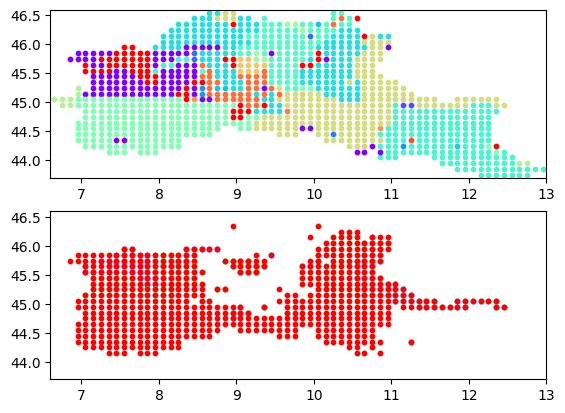

In [22]:
### for the plot:
path_target = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/csv_VHI/'
basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona','Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']
path_features='/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/features/csv_allvalues/temporal_aggreg/'

fig, ax = plt.subplots(2)
xmin=6.6
xmax=13
ymin=43.7
ymax=46.6
ax[0].set_xlim(xmin,xmax)
ax[1].set_xlim(xmin,xmax)
ax[0].set_ylim(ymin,ymax)
ax[1].set_ylim(ymin,ymax)

output_tot = []
### BOTH
for basin in basins:
    print('####################' + basin + '####################')

    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01', path=path_target+basin+'.csv')

    eps = 0.001
    actual_path = path_features+basin+'_aggreg.csv'
        
    output,aggregate_trainVal,aggregate_test = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg'],
                                                                       target_df_trainVal, eps=eps,
                                                                       max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')
    output_tot.append(output)
    selected_colnames = FS_with_linearWrapper(aggregate_trainVal, target_df_train, target_df_val, min(50,aggregate_trainVal.shape[1]-1), 228)
    
    plot_cells(output,selected_colnames)
        

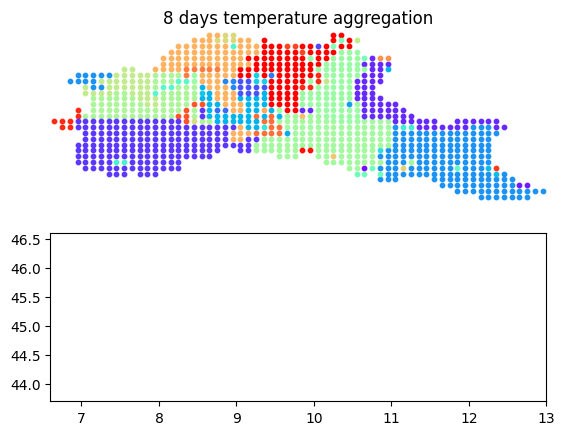

In [95]:
fig, ax = plt.subplots(2)
xmin=6.6
xmax=13
ymin=43.7
ymax=46.6
ax[0].set_xlim(xmin,xmax)
ax[1].set_xlim(xmin,xmax)
ax[0].set_ylim(ymin,ymax)
ax[1].set_ylim(ymin,ymax)

n_cols = 0
for i in range(10):
    output_tot[i]
    n_cols += len(output_tot[i])

colors = cm.rainbow(np.linspace(0,1,n_cols))
np.random.shuffle(colors)

colors_used = 0
for i in range(10):
    for j in range(len(output_tot[i])): 
        x = []
        y = []
        
        for datum in output_tot[i][j]:
            x.append(float(datum.split('_')[1]))
            y.append(float(datum.split('_')[2]))
        ax[0].scatter(x,y,color=colors[colors_used+j],s=10)
    colors_used += j
    ax[0].set_title('8 days temperature aggregation')
    ax[0].axis('off')

In [60]:
output_tot[0][0]

['mean_9.849860351582512_45.14986054634262']

In [89]:
### BOTH
for basin in basins:
    print('####################' + basin + '####################')

    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01', path=path_target+basin+'.csv')

    eps = 0.001
    actual_path = path_features+basin+'_aggreg.csv'
        
    output,aggregate_trainVal,aggregate_test = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg', 
                                                                             'cyclostationary_mean_tg_1w',
                                                                             'cyclostationary_mean_tg_4w', 
                                                                             'cyclostationary_mean_tg_8w',
                                                                             'cyclostationary_mean_tg_12w', 
                                                                             'cyclostationary_mean_tg_16w',
                                                                             'cyclostationary_mean_tg_24w',
                                                                             'cyclostationary_mean_rr', 
                                                                             'cyclostationary_mean_rr_1w',
                                                                             'cyclostationary_mean_rr_4w', 
                                                                             'cyclostationary_mean_rr_8w',
                                                                             'cyclostationary_mean_rr_12w', 
                                                                             'cyclostationary_mean_rr_16w',
                                                                             'cyclostationary_mean_rr_24w'
                                                                            ],
                                                                       target_df_trainVal, eps=eps,
                                                                       max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')
        
    selected_colnames = FS_with_linearWrapper(aggregate_trainVal, target_df_train, target_df_val, min(50,aggregate_trainVal.shape[1]-1), 228)

    print('\nFull model and selected features with wrapper\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)
    
    print('\nFull model and best 5 selected features with wrapper\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])
    
    res = {
            "delta" : [], 
            "numSelected" : [], 
            "selectedFeatures" : [] 
        }
        
    res['selectedFeatures'] = forwardFeatureSelection(10,np.array(aggregate_trainVal),np.array(target_df_trainVal.mean_std),res,10,1)
        
    selectedFeatures='selectedFeatures'
    print(f'\n{res[selectedFeatures]}\n')
    selected_colnames = aggregate_trainVal.columns[res['selectedFeatures']]
    
    print('\nFull model and selected features with CMI\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)
    
    print('\nFull model and best 5 selected features with CMI\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])
        

####################Adda####################
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.039373    0.00  2001     1 -2.546951
1    2001-01-13  0.380618    0.43  2001     2 -0.277191
2    2001-01-21  0.341985    0.38  2001     3 -0.534156
3    2001-01-29  0.322044    0.35  2001     5 -0.666789
4    2001-02-06  0.354954    0.40  2001     6 -0.447894
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.382706    0.40  2009    48 -0.263306
407  2009-12-05  0.409921    0.46  2009    49 -0.082282
408  2009-12-13  0.472087    0.53  2009    50  0.331204
409  2009-12-21  0.324728    0.00  2009    52 -0.648940
410  2009-12-29  0.086512    0.00  2009    53 -2.233412

[411 rows x 6 columns]
 target shapes: ((411, 6), (228, 6), (639, 6), (228, 6))
Number of features: 92

Number of aggregated features: 8

Number of features: 92

Number of aggregated features: 9

Number of features: 92

Number of aggregated features: 5

Number of fe

Number of features: 44

Number of aggregated features: 2

Number of features: 44

Number of aggregated features: 3

Number of features: 44

Number of aggregated features: 2

Number of features: 44

Number of aggregated features: 2

Number of features: 44

Number of aggregated features: 2

Number of features: 44

Number of aggregated features: 2

Number of features: 44

Number of aggregated features: 4

Number of features: 44

Number of aggregated features: 1

Number of features: 44

Number of aggregated features: 1

Number of features: 44

Number of aggregated features: 2

Number of features: 44

Number of aggregated features: 1

Number of features: 44

Number of aggregated features: 1

Number of features: 44

Number of aggregated features: 1

Number of features: 44

Number of aggregated features: 1



selected columns: ['cyclostationary_mean_tg_1w_0', 'cyclostationary_mean_rr_4w_1', 'cyclostationary_mean_tg_1w_2', 'cyclostationary_mean_tg_4w_1', 'cyclostationary_mean_tg_4w_0', 'cyclos

CMI: 0.059422610184022756
CMI: 0.08344032048162847
CMI: 0.0874155305635495
CMI: 0.08559965835763056
CMI: 0.06596853213705739
CMI: 0.06303210575080095
CMI: 0.06284285484306182
CMI: 0.05424357940746194
CMI: 0.091322367614044
CMI: 0.06476549225560713
CMI: 0.07728931618680496
CMI: 0.051392096266986015
CMI: 0.07057569441101699
CMI: 0.08285645279115222
CMI: 0.032400876149796615
CMI: 0.018215678152335907
CMI: 0.04594685168017951
CMI: 0.016459443379600813
CMI: 0.03284462966976684
CMI: 0.033727434173267595
CMI: 0.010229475147634809
CMI: 0.027269325489037183
CMI: 0.02278353506523012
CMI: 0.007349557148237151
CMI: 0.011287895643459861
CMI: 0.01851261942200008
CMI: 0.028309625223372437
CMI: 0.030101749114442994
CMI: 0.012399966630382786
CMI: 0.022065880455486214
CMI: 0.025990989592044517
CMI: 0.03063863073056952
CMI: 0.016793362059533273
CMI: 0.03139594446228572
CMI: 0.006507761518240174
CMI: 0.009799779638487133
CMI: 0.034559155561560084
CMI: 0.014135541637238347
CMI: 0.02790772232711819
CMI: 0.0

CMI: 0.018469644675450425
CMI: 0.003173695655592529
CMI: 0.009070013243910047
CMI: 0.013175208376939557
CMI: 0.009242010891818864
CMI: 0.005901752730679832
CMI: 0.004317827344836489
CMI: 0.015443886916817362
CMI: 0.02951111910987672
CMI: 0.01874997708569051
CMI: 0.06516316996146612
CMI: 0.02823472473599603
CMI: 0.018462289385866276
CMI: 0.037969661548884426
CMI: 0.01122604563079585
CMI: 0.027737577667498847
CMI: 0.008689093606747827
CMI: 0.019027692789901768
CMI: 0.025655887599053268
CMI: 0.013287241670572852
CMI: 0.010677041626155098
CMI: 0.005905132456976769
CMI: 0.02357653001496854
CMI: 0.004896054729931237
CMI: 0.02548206891251545
Highest CMI score: 0.06516316996146612
Adding original feature: 65
CMI: 0.00900775757513439
CMI: 0.011121784812033048
CMI: 0.007835685081765548
CMI: 0.0020391175991993082
CMI: 0.009581599546292674
CMI: 0.009259090214488869
CMI: 0.0006220508325395224
Highest CMI score: 0.011121784812033048
Adding original feature: 4
CMI: 0.002594938061139973
CMI: 0.0030029

CMI: 0.010813029370204397
Highest CMI score: 0.010813029370204397
Adding original feature: 34
CMI: 0.012900291492338706
CMI: 0.0008162102416908179
Highest CMI score: 0.012900291492338706
Adding original feature: 7
CMI: 0.00014014792231964446
Highest CMI score: 0.00014014792231964446
Adding original feature: 26
Highest CMI score: -0.0011303433178878608

[25, 0, 29, 34, 7, 26]


Full model and selected features with CMI

Full aggregate regression train score: 0.3422882680157445, test score: 0.0182751309530802
Aggregate regression train score with FS: 0.23723664847423453, test score: 0.20648970940272304

Full model and best 5 selected features with CMI

Full aggregate regression train score: 0.3422882680157445, test score: 0.0182751309530802
Aggregate regression train score with FS: 0.21930815256082514, test score: 0.19688361981680602
####################Lambro_Olona####################
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.369625    0.

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1



selected columns: ['cyclostationary_mean_tg_1w_4', 'cyclostationary_mean_rr_1w_0', 'cyclostationary_mean_rr_1w_1', 'cyclostationary_mean_tg_12w_1', 'cyclostationary_mean_tg_1w_2', 'cyclostationary_mean_tg_1w_0', 'cyclostationary_mean_rr_16w_0', 'cyclostationary_mean_rr_8w_0', 'cyclostationary_mean_tg_12w_2', 'cyclostationary_mean_tg_8w_3', 'cyclostationary_mean_tg_1w_5'], 

validation score: 0.29691836079644107, 

number of selected features: 11

Full model and selected features with wrapper

Full aggregate regression train score: 0.27617133804962757, test score: -0.03573075455503871
Aggregate regression train score with FS: 0.23248703741861187, test score: 0.15120442094434638

Full model and best 5

CMI: 0.003996013869582954
CMI: 0.02801289279423999
CMI: 0.022750208809280387
CMI: 0.024493548072650195
CMI: 0.005126950507696015
CMI: 0.026068307490465237
Highest CMI score: 0.02801289279423999
Adding original feature: 31
CMI: 0.012058698024091263
CMI: 0.008014996072354647
CMI: 0.005784212341584327
CMI: 0.0048638057060270135
CMI: 0.010711624133859982
CMI: 0.012701478913980241
CMI: 0.020252191019192956
CMI: 0.012273370204484824
CMI: 0.012692411560226186
CMI: 0.014281674163654973
CMI: 0.014442687384270597
CMI: 0.0013287110970462146
CMI: 0.0025512706459644985
CMI: 0.0035517244924000158
CMI: 0.003727240736091708
CMI: 0.006265984242040806
CMI: 0.007420925823884539
Highest CMI score: 0.020252191019192956
Adding original feature: 7
CMI: 0.0028048132988725827
CMI: 0.0036452635358895924
CMI: 0.0005519262482181209
CMI: 0.004405083316340291
CMI: 0.0012605419474807644
CMI: 0.001161476675276163
Highest CMI score: 0.004405083316340291
Adding original feature: 9
CMI: 0.0010648378299236427
CMI: 0.0006

Number of features: 92

Number of aggregated features: 4

Number of features: 92

Number of aggregated features: 5

Number of features: 92

Number of aggregated features: 6

Number of features: 92

Number of aggregated features: 7

Number of features: 92

Number of aggregated features: 6

Number of features: 92

Number of aggregated features: 9

Number of features: 92

Number of aggregated features: 5

Number of features: 92

Number of aggregated features: 1

Number of features: 92

Number of aggregated features: 2

Number of features: 92

Number of aggregated features: 1

Number of features: 92

Number of aggregated features: 1

Number of features: 92

Number of aggregated features: 1

Number of features: 92

Number of aggregated features: 2

Number of features: 92

Number of aggregated features: 2



selected columns: ['cyclostationary_mean_tg_1w_3', 'cyclostationary_mean_rr_1w_1', 'cyclostationary_mean_tg_16w_3', 'cyclostationary_mean_rr_24w_0', 'cyclostationary_mean_rr_24w_1', 'cyc

In [21]:
52 + 25 + 92 + 91 + 47 + 53 + 37 + 38 + 62 + 52

549

In [90]:
### PRECIPITATION
for basin in basins:
    print('####################' + basin + '####################')

    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01', path=path_target+basin+'.csv')

    eps = 0.001
    actual_path = path_features+basin+'_aggreg.csv'
        
    output,aggregate_trainVal,aggregate_test = aggregate_unfolded_data(actual_path,[
                                                                             'cyclostationary_mean_rr', 
                                                                             'cyclostationary_mean_rr_1w',
                                                                             'cyclostationary_mean_rr_4w', 
                                                                             'cyclostationary_mean_rr_8w',
                                                                             'cyclostationary_mean_rr_12w', 
                                                                             'cyclostationary_mean_rr_16w',
                                                                             'cyclostationary_mean_rr_24w'
                                                                            ],
                                                                       target_df_trainVal, eps=eps,
                                                                       max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')
        
    selected_colnames = FS_with_linearWrapper(aggregate_trainVal, target_df_train, target_df_val, min(50,aggregate_trainVal.shape[1]-1), 228)

    print('\nFull model and selected features with wrapper\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)
    
    print('\nFull model and best 5 selected features with wrapper\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])
    
    res = {
            "delta" : [], 
            "numSelected" : [], 
            "selectedFeatures" : [] 
        }
        
    res['selectedFeatures'] = forwardFeatureSelection(10,np.array(aggregate_trainVal),np.array(target_df_trainVal.mean_std),res,10,1)
        
    selectedFeatures='selectedFeatures'
    print(f'\n{res[selectedFeatures]}\n')
    selected_colnames = aggregate_trainVal.columns[res['selectedFeatures']]
    
    print('\nFull model and selected features with CMI\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)
    
    print('\nFull model and best 5 selected features with CMI\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])
        

####################Adda####################
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.039373    0.00  2001     1 -2.546951
1    2001-01-13  0.380618    0.43  2001     2 -0.277191
2    2001-01-21  0.341985    0.38  2001     3 -0.534156
3    2001-01-29  0.322044    0.35  2001     5 -0.666789
4    2001-02-06  0.354954    0.40  2001     6 -0.447894
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.382706    0.40  2009    48 -0.263306
407  2009-12-05  0.409921    0.46  2009    49 -0.082282
408  2009-12-13  0.472087    0.53  2009    50  0.331204
409  2009-12-21  0.324728    0.00  2009    52 -0.648940
410  2009-12-29  0.086512    0.00  2009    53 -2.233412

[411 rows x 6 columns]
 target shapes: ((411, 6), (228, 6), (639, 6), (228, 6))
Number of features: 92

Number of aggregated features: 5

Number of features: 92

Number of aggregated features: 1

Number of features: 92

Number of aggregated features: 1

Number of fe

----- MI Scores -----
[(10, 0.17504095111370133), (15, 0.15685898782413568), (5, 0.15663937732758673), (18, 0.14787966881080428), (6, 0.13358919003654968), (7, 0.12977497478467878), (19, 0.12591588912581234), (16, 0.12502097862347125), (17, 0.1174637256279963), (21, 0.10962030446771408), (23, 0.10961907837925046), (8, 0.10702596822093491), (14, 0.10072196697341092), (26, 0.0992424123725184), (3, 0.0947850582391767), (13, 0.08868657617391486), (11, 0.08491125367340009), (24, 0.08402362739122736), (0, 0.08102303869713054), (22, 0.0806249900148661), (2, 0.07987489902048975), (12, 0.07980996407790779), (20, 0.07882279717747617), (25, 0.07454060217936176), (4, 0.0711278011636932), (9, 0.07003092866531786), (27, 0.0683177943511003), (1, 0.06727264443867055), (28, 0.06169209136380296)]
Best MI score: 0.17504095111370133
Adding first best original feature: 10
CMI: 0.04245298082741003
CMI: 0.012318401276596308
CMI: 0.04057892766216176
CMI: 0.02651045367331864
CMI: 0.04662560862903398
CMI: 0.055

Number of features: 67

Number of aggregated features: 5

Number of features: 67

Number of aggregated features: 5

Number of features: 67

Number of aggregated features: 4

Number of features: 67

Number of aggregated features: 3

Number of features: 67

Number of aggregated features: 3

Number of features: 67

Number of aggregated features: 5

Number of features: 67

Number of aggregated features: 7



selected columns: ['cyclostationary_mean_rr_4w_1', 'cyclostationary_mean_rr_16w_1', 'cyclostationary_mean_rr_24w_4', 'cyclostationary_mean_rr_24w_1', 'cyclostationary_mean_rr_1w_1', 'cyclostationary_mean_rr_4w_0', 'cyclostationary_mean_rr_1w_4', 'cyclostationary_mean_rr_8w_2', 'cyclostationary_mean_rr_16w_2', 'cyclostationary_mean_rr_24w_3'], 

validation score: 0.23041333116129237, 

number of selected features: 10

Full model and selected features with wrapper

Full aggregate regression train score: 0.25381713358337643, test score: 0.10898878203768514
Aggregate regression train score

Number of features: 74

Number of aggregated features: 3

Number of features: 74

Number of aggregated features: 4

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1



selected columns: ['cyclostationary_mean_rr_1w_0', 'cyclostationary_mean_rr_1w_1', 'cyclostationary_mean_rr_8w_0'], 

validation score: 0.06217459950491211, 

number of selected features: 3

Full model and selected features with wrapper

Full aggregate regression train score: 0.09297311138378295, test score: 0.06296006158946232
Aggregate regression train score with FS: 0.08409118611379773, test score: 0.06428185955827403

Full model and best 5 selected features with wrapper

Full aggregate regression train score: 0.09297311138378295, test score: 0.06296006158946232
Aggregate regression

CMI: 0.002897375552813622
CMI: 0.002483851850279037
CMI: 0.005123467780271632
CMI: 0.011308203184349858
CMI: 0.027326797156956115
CMI: 0.016152805931000755
CMI: 0.015584826841586297
CMI: 0.01666989833369191
CMI: 0.010991639969905098
Highest CMI score: 0.027326797156956115
Adding original feature: 33
CMI: 0.0015029814569432753
CMI: 0.0005186845991588807
CMI: 0.004718374751983612
CMI: 0.015375143768368849
CMI: 0.01199987447031614
CMI: 0.006275279884718377
CMI: 0.011206932138755343
CMI: 0.004616120513452365
CMI: 0.015837608820982646
CMI: 0.004791054388901622
CMI: 0.0038232058594465934
CMI: 0.012107019395216079
CMI: 0.003127573775548398
CMI: 0.012774559811218833
CMI: 0.009207001359839262
CMI: 0.018889918682798074
CMI: 0.01459949400406474
Highest CMI score: 0.018889918682798074
Adding original feature: 38
CMI: 0.0035669570143130325
CMI: 0.002078618992768566
CMI: 0.0034735097447738117
CMI: 0.015366516327556146
CMI: 0.006321202526327396
CMI: 0.00396422031433008
CMI: 0.019730932580918348
Highe

In [91]:
### TEMPERATURE
for basin in basins:
    print('####################' + basin + '####################')

    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01', path=path_target+basin+'.csv')

    eps = 0.001
    actual_path = path_features+basin+'_aggreg.csv'
        
    output,aggregate_trainVal,aggregate_test = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg', 
                                                                             'cyclostationary_mean_tg_1w',
                                                                             'cyclostationary_mean_tg_4w', 
                                                                             'cyclostationary_mean_tg_8w',
                                                                             'cyclostationary_mean_tg_12w', 
                                                                             'cyclostationary_mean_tg_16w',
                                                                             'cyclostationary_mean_tg_24w'
                                                                            ],
                                                                       target_df_trainVal, eps=eps,
                                                                       max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')
        
    selected_colnames = FS_with_linearWrapper(aggregate_trainVal, target_df_train, target_df_val, min(50,aggregate_trainVal.shape[1]-1), 228)

    print('\nFull model and selected features with wrapper\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)
    
    print('\nFull model and best 5 selected features with wrapper\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])
    
    res = {
            "delta" : [], 
            "numSelected" : [], 
            "selectedFeatures" : [] 
        }
        
    res['selectedFeatures'] = forwardFeatureSelection(10,np.array(aggregate_trainVal),np.array(target_df_trainVal.mean_std),res,10,1)
        
    selectedFeatures='selectedFeatures'
    print(f'\n{res[selectedFeatures]}\n')
    selected_colnames = aggregate_trainVal.columns[res['selectedFeatures']]
    
    print('\nFull model and selected features with CMI\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)
    
    print('\nFull model and best 5 selected features with CMI\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])
        

####################Adda####################
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.039373    0.00  2001     1 -2.546951
1    2001-01-13  0.380618    0.43  2001     2 -0.277191
2    2001-01-21  0.341985    0.38  2001     3 -0.534156
3    2001-01-29  0.322044    0.35  2001     5 -0.666789
4    2001-02-06  0.354954    0.40  2001     6 -0.447894
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.382706    0.40  2009    48 -0.263306
407  2009-12-05  0.409921    0.46  2009    49 -0.082282
408  2009-12-13  0.472087    0.53  2009    50  0.331204
409  2009-12-21  0.324728    0.00  2009    52 -0.648940
410  2009-12-29  0.086512    0.00  2009    53 -2.233412

[411 rows x 6 columns]
 target shapes: ((411, 6), (228, 6), (639, 6), (228, 6))
Number of features: 92

Number of aggregated features: 8

Number of features: 92

Number of aggregated features: 9

Number of features: 92

Number of aggregated features: 5

Number of fe

CMI: 0.006332958677283118
CMI: 0.0009995828970427445
Highest CMI score: 0.006332958677283118
Adding original feature: 10
CMI: 0.0011758238990016712
CMI: 0.00042950159352572737
Highest CMI score: 0.0011758238990016712
Adding original feature: 5
Highest CMI score: -0.004053613515285048

[6, 9, 14, 2, 10, 5]


Full model and selected features with CMI

Full aggregate regression train score: 0.1330435926364978, test score: -0.28162416569045723
Aggregate regression train score with FS: 0.1107279850394518, test score: -0.24692734368251967

Full model and best 5 selected features with CMI

Full aggregate regression train score: 0.1330435926364978, test score: -0.28162416569045723
Aggregate regression train score with FS: 0.10964127248875943, test score: -0.2499174440028924
####################Emiliani1####################
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.379890    0.50  2001     1 -0.382765
1    2001-01-13  0.482679    0.58  2001     2

Number of features: 130

Number of aggregated features: 7

Number of features: 130

Number of aggregated features: 8

Number of features: 130

Number of aggregated features: 8

Number of features: 130

Number of aggregated features: 4

Number of features: 130

Number of aggregated features: 3

Number of features: 130

Number of aggregated features: 4

Number of features: 130

Number of aggregated features: 4



selected columns: ['cyclostationary_mean_tg_1w_5', 'cyclostationary_mean_tg_4w_1', 'cyclostationary_mean_tg_1w_6', 'cyclostationary_mean_tg_4w_0', 'cyclostationary_mean_tg_4w_3', 'cyclostationary_mean_tg_4w_4', 'cyclostationary_mean_tg_24w_3', 'cyclostationary_mean_tg_4w_7', 'cyclostationary_mean_tg_1w_4', 'cyclostationary_mean_tg_1w_7', 'cyclostationary_mean_tg_1w_0', 'cyclostationary_mean_tg_16w_3'], 

validation score: 0.3985074663753776, 

number of selected features: 12

Full model and selected features with wrapper

Full aggregate regression train score: 0.3820043929592641

Number of features: 55

Number of aggregated features: 4

Number of features: 55

Number of aggregated features: 5

Number of features: 55

Number of aggregated features: 3



selected columns: ['cyclostationary_mean_tg_1w_2', 'cyclostationary_mean_tg_1w_7', 'cyclostationary_mean_tg_1w_5', 'cyclostationary_mean_tg_24w_1', 'cyclostationary_mean_tg_1w_6', 'cyclostationary_mean_tg_1w_0', 'cyclostationary_mean_tg_4w_0', 'cyclostationary_mean_tg_4w_5', 'cyclostationary_mean_tg_4w_1', 'cyclostationary_mean_tg_8w_2', 'cyclostationary_mean_tg_4w_6', 'cyclostationary_mean_tg_16w_3', 'cyclostationary_mean_tg_16w_0', 'cyclostationary_mean_tg_24w_0', 'cyclostationary_mean_tg_12w_2', 'cyclostationary_mean_tg_12w_0', 'cyclostationary_mean_tg_8w_0', 'cyclostationary_mean_tg_24w_2', 'cyclostationary_mean_tg_8w_3'], 

validation score: 0.38271634400988364, 

number of selected features: 19

Full model and selected features with wrapper

Full aggregate regression train score: 0.35370889255178417, test s

Highest CMI score: -0.0010839083679136108

[3, 17, 1, 2]


Full model and selected features with CMI

Full aggregate regression train score: 0.23875773857715754, test score: -0.053340137943577615
Aggregate regression train score with FS: 0.1396877428715838, test score: 0.17515015087958297

Full model and best 5 selected features with CMI

Full aggregate regression train score: 0.23875773857715754, test score: -0.053340137943577615
Aggregate regression train score with FS: 0.1396877428715838, test score: 0.17515015087958297
####################Piemonte_Nord####################
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.278983    0.00  2001     1 -1.146332
1    2001-01-13  0.494910    0.51  2001     2  0.371173
2    2001-01-21  0.496092    0.51  2001     3  0.379474
3    2001-01-29  0.427992    0.43  2001     5 -0.099118
4    2001-02-06  0.400512    0.41  2001     6 -0.292244
..          ...       ...     ...   ...   ...       ...
406  2009

CMI: 0.0012204494528582632
Highest CMI score: 0.0012204494528582632
Adding original feature: 18
Highest CMI score: -0.0005773657972916735

[0, 19, 9, 21, 8, 2, 17, 18]


Full model and selected features with CMI

Full aggregate regression train score: 0.2274765887229937, test score: -0.08651284208294463
Aggregate regression train score with FS: 0.16234967636583897, test score: -0.046915678506039615

Full model and best 5 selected features with CMI

Full aggregate regression train score: 0.2274765887229937, test score: -0.08651284208294463
Aggregate regression train score with FS: 0.1330466536401056, test score: 0.11415657221011966
####################Ticino####################
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.264043    0.00  2001     1 -1.060146
1    2001-01-13  0.354618    0.39  2001     2 -0.405065
2    2001-01-21  0.427990    0.47  2001     3  0.125603
3    2001-01-29  0.339495    0.35  2001     5 -0.514438
4    2001-02-06  0

# Altro

In [42]:
best_epsilon_wrapper = []
best_epsilon_wrapper_best5 = []
best_epsilon_CMI = []
best_epsilon_CMI_best5 = []

for basin in basins:
    current_max = max([ v for k, v in val_res_wrapper.items() if k.startswith(basin)])
    best_epsilon_wrapper.append([ [k,v] for k, v in val_res_wrapper.items() if v==current_max][0][0])
    
    current_max = max([ v for k, v in val_res_wrapper_best5.items() if k.startswith(basin)])
    best_epsilon_wrapper_best5.append([ [k,v] for k, v in val_res_wrapper_best5.items() if v==current_max][0][0])
    
    current_max = max([ v for k, v in val_res_CMI.items() if k.startswith(basin)])
    best_epsilon_CMI.append([ [k,v] for k, v in val_res_CMI.items() if v==current_max][0][0])
    
    current_max = max([ v for k, v in val_res_CMI_best5.items() if k.startswith(basin)])
    best_epsilon_CMI_best5.append([ [k,v] for k, v in val_res_CMI_best5.items() if v==current_max][0][0])
    

In [3]:
### BOTH
path_target = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/csv_VHI/'
basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona','Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']
path_features='/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/features/csv_allvalues/temporal_aggreg/'

for basin in basins:
    print('####################' + basin + '####################')

    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01', path=path_target+basin+'.csv')

    eps = 0.001
    actual_path = path_features+basin+'_aggreg.csv'
        
    output,aggregate_trainVal,aggregate_test = aggregate_unfolded_data(actual_path,['cyclostationary_mean_tg', 
                                                                             'cyclostationary_mean_tg_1w',
                                                                             'cyclostationary_mean_tg_4w', 
                                                                             'cyclostationary_mean_tg_8w',
                                                                             'cyclostationary_mean_tg_12w', 
                                                                             'cyclostationary_mean_tg_16w',
                                                                             'cyclostationary_mean_tg_24w',
                                                                             'cyclostationary_mean_rr', 
                                                                             'cyclostationary_mean_rr_1w',
                                                                             'cyclostationary_mean_rr_4w', 
                                                                             'cyclostationary_mean_rr_8w',
                                                                             'cyclostationary_mean_rr_12w', 
                                                                             'cyclostationary_mean_rr_16w',
                                                                             'cyclostationary_mean_rr_24w'
                                                                            ],
                                                                       target_df_trainVal, eps=eps,
                                                                       max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')
        
    selected_colnames = FS_with_linearWrapper(aggregate_trainVal, target_df_train, target_df_val, min(50,aggregate_trainVal.shape[1]-1), 228)

    print('\nFull model and selected features with wrapper\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)
    
    print('\nFull model and best 5 selected features with wrapper\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])
    
    train_string = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features/'+basin+'_nonLinCFA_wrapper_best5_train.csv'
    val_string = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features/'+basin+'_nonLinCFA_wrapper_best5_val.csv'
    test_string = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features/'+basin+'_nonLinCFA_wrapper_best5_test.csv'
    aggregate_trainVal.loc[:410,selected_colnames[0:5]].to_csv(train_string, index=False)
    aggregate_trainVal.loc[411:,selected_colnames[0:5]].to_csv(val_string, index=False)
    aggregate_test.loc[:,selected_colnames[0:5]].to_csv(test_string, index=False)

    res = {
            "delta" : [], 
            "numSelected" : [], 
            "selectedFeatures" : [] 
        }
        
    res['selectedFeatures'] = forwardFeatureSelection(10,np.array(aggregate_trainVal),np.array(target_df_trainVal.mean_std),res,10,1)
        
    selectedFeatures='selectedFeatures'
    print(f'\n{res[selectedFeatures]}\n')
    selected_colnames = aggregate_trainVal.columns[res['selectedFeatures']]
    
    print('\nFull model and selected features with CMI\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)
    
    print('\nFull model and best 5 selected features with CMI\n')
    compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])
        
    train_string = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features/'+basin+'_nonLinCFA_best5_CMI_train.csv'
    val_string = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features/'+basin+'_nonLinCFA_best5_CMI_val.csv'
    test_string = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features/'+basin+'_nonLinCFA_best5_CMI_test.csv'
            
    aggregate_trainVal.loc[:410,selected_colnames[0:5]].to_csv(train_string, index=False)
    aggregate_trainVal.loc[411:,selected_colnames[0:5]].to_csv(val_string, index=False)
    aggregate_test.loc[:,selected_colnames[0:5]].to_csv(test_string, index=False)

    train_string = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features/'+basin+'_nonLinCFA_CMI_train.csv'
    val_string = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features/'+basin+'_nonLinCFA_CMI_val.csv'
    test_string = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features/'+basin+'_nonLinCFA_CMI_test.csv'
        
    aggregate_trainVal.loc[:410,selected_colnames].to_csv(train_string, index=False)
    aggregate_trainVal.loc[411:,selected_colnames].to_csv(val_string, index=False)
    aggregate_test.loc[:,selected_colnames].to_csv(test_string, index=False)

    

####################Adda####################
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.039373    0.00  2001     1 -2.546951
1    2001-01-13  0.380618    0.43  2001     2 -0.277191
2    2001-01-21  0.341985    0.38  2001     3 -0.534156
3    2001-01-29  0.322044    0.35  2001     5 -0.666789
4    2001-02-06  0.354954    0.40  2001     6 -0.447894
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.382706    0.40  2009    48 -0.263306
407  2009-12-05  0.409921    0.46  2009    49 -0.082282
408  2009-12-13  0.472087    0.53  2009    50  0.331204
409  2009-12-21  0.324728    0.00  2009    52 -0.648940
410  2009-12-29  0.086512    0.00  2009    53 -2.233412

[411 rows x 6 columns]
 target shapes: ((411, 6), (228, 6), (639, 6), (228, 6))
Number of features: 92

Number of aggregated features: 8

Number of features: 92

Number of aggregated features: 9

Number of features: 92

Number of aggregated features: 5

Number of fe

Number of features: 44

Number of aggregated features: 2

Number of features: 44

Number of aggregated features: 3

Number of features: 44

Number of aggregated features: 2

Number of features: 44

Number of aggregated features: 2

Number of features: 44

Number of aggregated features: 2

Number of features: 44

Number of aggregated features: 2

Number of features: 44

Number of aggregated features: 4

Number of features: 44

Number of aggregated features: 1

Number of features: 44

Number of aggregated features: 1

Number of features: 44

Number of aggregated features: 2

Number of features: 44

Number of aggregated features: 1

Number of features: 44

Number of aggregated features: 1

Number of features: 44

Number of aggregated features: 1

Number of features: 44

Number of aggregated features: 1



selected columns: ['cyclostationary_mean_tg_1w_0', 'cyclostationary_mean_rr_4w_1', 'cyclostationary_mean_tg_1w_2', 'cyclostationary_mean_tg_4w_1', 'cyclostationary_mean_tg_4w_0', 'cyclos

CMI: 0.059422610184022756
CMI: 0.08344032048162847
CMI: 0.0874155305635495
CMI: 0.08559965835763056
CMI: 0.06596853213705739
CMI: 0.06303210575080095
CMI: 0.06284285484306182
CMI: 0.05424357940746194
CMI: 0.091322367614044
CMI: 0.06476549225560713
CMI: 0.07728931618680496
CMI: 0.051392096266986015
CMI: 0.07057569441101699
CMI: 0.08285645279115222
CMI: 0.032400876149796615
CMI: 0.018215678152335907
CMI: 0.04594685168017951
CMI: 0.016459443379600813
CMI: 0.03284462966976684
CMI: 0.033727434173267595
CMI: 0.010229475147634809
CMI: 0.027269325489037183
CMI: 0.02278353506523012
CMI: 0.007349557148237151
CMI: 0.011287895643459861
CMI: 0.01851261942200008
CMI: 0.028309625223372437
CMI: 0.030101749114442994
CMI: 0.012399966630382786
CMI: 0.022065880455486214
CMI: 0.025990989592044517
CMI: 0.03063863073056952
CMI: 0.016793362059533273
CMI: 0.03139594446228572
CMI: 0.006507761518240174
CMI: 0.009799779638487133
CMI: 0.034559155561560084
CMI: 0.014135541637238347
CMI: 0.02790772232711819
CMI: 0.0

CMI: 0.018469644675450425
CMI: 0.003173695655592529
CMI: 0.009070013243910047
CMI: 0.013175208376939557
CMI: 0.009242010891818864
CMI: 0.005901752730679832
CMI: 0.004317827344836489
CMI: 0.015443886916817362
CMI: 0.02951111910987672
CMI: 0.01874997708569051
CMI: 0.06516316996146612
CMI: 0.02823472473599603
CMI: 0.018462289385866276
CMI: 0.037969661548884426
CMI: 0.01122604563079585
CMI: 0.027737577667498847
CMI: 0.008689093606747827
CMI: 0.019027692789901768
CMI: 0.025655887599053268
CMI: 0.013287241670572852
CMI: 0.010677041626155098
CMI: 0.005905132456976769
CMI: 0.02357653001496854
CMI: 0.004896054729931237
CMI: 0.02548206891251545
Highest CMI score: 0.06516316996146612
Adding original feature: 65
CMI: 0.00900775757513439
CMI: 0.011121784812033048
CMI: 0.007835685081765548
CMI: 0.0020391175991993082
CMI: 0.009581599546292674
CMI: 0.009259090214488869
CMI: 0.0006220508325395224
Highest CMI score: 0.011121784812033048
Adding original feature: 4
CMI: 0.002594938061139973
CMI: 0.0030029

CMI: 0.010813029370204397
Highest CMI score: 0.010813029370204397
Adding original feature: 34
CMI: 0.012900291492338706
CMI: 0.0008162102416908179
Highest CMI score: 0.012900291492338706
Adding original feature: 7
CMI: 0.00014014792231964446
Highest CMI score: 0.00014014792231964446
Adding original feature: 26
Highest CMI score: -0.0011303433178878608

[25, 0, 29, 34, 7, 26]


Full model and selected features with CMI

Full aggregate regression train score: 0.3422882680157445, test score: 0.0182751309530802
Aggregate regression train score with FS: 0.23723664847423453, test score: 0.20648970940272304

Full model and best 5 selected features with CMI

Full aggregate regression train score: 0.3422882680157445, test score: 0.0182751309530802
Aggregate regression train score with FS: 0.21930815256082514, test score: 0.19688361981680602
####################Lambro_Olona####################
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.369625    0.

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1

Number of features: 74

Number of aggregated features: 1



selected columns: ['cyclostationary_mean_tg_1w_4', 'cyclostationary_mean_rr_1w_0', 'cyclostationary_mean_rr_1w_1', 'cyclostationary_mean_tg_12w_1', 'cyclostationary_mean_tg_1w_2', 'cyclostationary_mean_tg_1w_0', 'cyclostationary_mean_rr_16w_0', 'cyclostationary_mean_rr_8w_0', 'cyclostationary_mean_tg_12w_2', 'cyclostationary_mean_tg_8w_3', 'cyclostationary_mean_tg_1w_5'], 

validation score: 0.29691836079644107, 

number of selected features: 11

Full model and selected features with wrapper

Full aggregate regression train score: 0.27617133804962757, test score: -0.03573075455503871
Aggregate regression train score with FS: 0.23248703741861187, test score: 0.15120442094434638

Full model and best 5

CMI: 0.003996013869582954
CMI: 0.02801289279423999
CMI: 0.022750208809280387
CMI: 0.024493548072650195
CMI: 0.005126950507696015
CMI: 0.026068307490465237
Highest CMI score: 0.02801289279423999
Adding original feature: 31
CMI: 0.012058698024091263
CMI: 0.008014996072354647
CMI: 0.005784212341584327
CMI: 0.0048638057060270135
CMI: 0.010711624133859982
CMI: 0.012701478913980241
CMI: 0.020252191019192956
CMI: 0.012273370204484824
CMI: 0.012692411560226186
CMI: 0.014281674163654973
CMI: 0.014442687384270597
CMI: 0.0013287110970462146
CMI: 0.0025512706459644985
CMI: 0.0035517244924000158
CMI: 0.003727240736091708
CMI: 0.006265984242040806
CMI: 0.007420925823884539
Highest CMI score: 0.020252191019192956
Adding original feature: 7
CMI: 0.0028048132988725827
CMI: 0.0036452635358895924
CMI: 0.0005519262482181209
CMI: 0.004405083316340291
CMI: 0.0012605419474807644
CMI: 0.001161476675276163
Highest CMI score: 0.004405083316340291
Adding original feature: 9
CMI: 0.0010648378299236427
CMI: 0.0006

Number of features: 92

Number of aggregated features: 4

Number of features: 92

Number of aggregated features: 5

Number of features: 92

Number of aggregated features: 6

Number of features: 92

Number of aggregated features: 7

Number of features: 92

Number of aggregated features: 6

Number of features: 92

Number of aggregated features: 9

Number of features: 92

Number of aggregated features: 5

Number of features: 92

Number of aggregated features: 1

Number of features: 92

Number of aggregated features: 2

Number of features: 92

Number of aggregated features: 1

Number of features: 92

Number of aggregated features: 1

Number of features: 92

Number of aggregated features: 1

Number of features: 92

Number of aggregated features: 2

Number of features: 92

Number of aggregated features: 2



selected columns: ['cyclostationary_mean_tg_1w_3', 'cyclostationary_mean_rr_1w_1', 'cyclostationary_mean_tg_16w_3', 'cyclostationary_mean_rr_24w_0', 'cyclostationary_mean_rr_24w_1', 'cyc

In [18]:
res = {
            "delta" : [], 
            "numSelected" : [], 
            "selectedFeatures" : [] 
        }
        
res['selectedFeatures'] = forwardFeatureSelection(10,np.array(aggregate_trainVal),np.array(target_df_trainVal.mean_std),res,10,1)
    
selectedFeatures='selectedFeatures'
print(f'\n{res[selectedFeatures]}\n')
selected_colnames = aggregate_trainVal.columns[res['selectedFeatures']]

print('\nFull model and selected features with CMI\n')
compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames)

print('\nFull model and best 5 selected features with CMI\n')
compare_methods(aggregate_trainVal, aggregate_test, target_df_trainVal, target_df_test, selected_colnames[0:5])
        

----- MI Scores -----
[(11, 0.15246918228231238), (62, 0.13685487884232336), (73, 0.13524591194316204), (4, 0.1349170730411436), (12, 0.13069123294496232), (2, 0.13065462984779644), (10, 0.1231135469682487), (0, 0.12179110241277581), (1, 0.11185209883590831), (8, 0.10986275099519403), (65, 0.09926803152018446), (3, 0.09837955367460148), (6, 0.09674503527089101), (66, 0.0966209825430217), (75, 0.09623197123570164), (72, 0.09324017948760668), (79, 0.09207223934751455), (67, 0.09104982381307869), (74, 0.09054955462491504), (22, 0.09003186611152561), (71, 0.08873753149051027), (13, 0.08840980007656025), (63, 0.08674288030600526), (5, 0.08633953056624281), (42, 0.08551713286237457), (7, 0.08332675656174225), (70, 0.08179196380125643), (41, 0.08158274429258124), (84, 0.08130184534173333), (38, 0.07919816591699666), (78, 0.07608865743150646), (81, 0.07593527481570693), (49, 0.07551138688433962), (51, 0.07515073162512392), (61, 0.07453154808910913), (45, 0.07370388129928994), (64, 0.0727260798

0.23062800854005472

In [26]:
target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01', path=path_target+'Ticino.csv')

train = pd.read_csv('/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features/Ticino_nonLinCFA_best5_CMI_train.csv')
val = pd.read_csv('/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features/Ticino_nonLinCFA_best5_CMI_val.csv')
trainVal = pd.concat((train,val),axis=0)
test = pd.read_csv('/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features/Ticino_nonLinCFA_best5_CMI_test.csv')



target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.264043    0.00  2001     1 -1.060146
1    2001-01-13  0.354618    0.39  2001     2 -0.405065
2    2001-01-21  0.427990    0.47  2001     3  0.125603
3    2001-01-29  0.339495    0.35  2001     5 -0.514438
4    2001-02-06  0.324134    0.34  2001     6 -0.625540
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.332713    0.35  2009    48 -0.563495
407  2009-12-05  0.370253    0.40  2009    49 -0.291984
408  2009-12-13  0.517201    0.57  2009    50  0.770822
409  2009-12-21  0.353636    0.45  2009    52 -0.412164
410  2009-12-29  0.261079    0.00  2009    53 -1.081585

[411 rows x 6 columns]
 target shapes: ((411, 6), (228, 6), (639, 6), (228, 6))


In [27]:
compare_methods(trainVal, test, target_df_trainVal, target_df_test, list(trainVal.columns))


Full aggregate regression train score: 0.18673632578571386, test score: 0.16805571817724296
Aggregate regression train score with FS: 0.18673632578571386, test score: 0.16805571817724296


0.16805571817724296

In [3]:
import pandas as pd
pd.read_csv('/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/features/csv_allvalues/temporal_aggreg/Adda_aggreg.csv')


,date,y,x,year,week,cyclostationary_mean_tg,cyclostationary_mean_rr,cyclostationary_mean_tg_1w,cyclostationary_mean_tg_4w,cyclostationary_mean_tg_8w,cyclostationary_mean_tg_12w,cyclostationary_mean_tg_16w,cyclostationary_mean_tg_24w,cyclostationary_mean_rr_1w,cyclostationary_mean_rr_4w,cyclostationary_mean_rr_8w,cyclostationary_mean_rr_12w,cyclostationary_mean_rr_16w,cyclostationary_mean_rr_24w
0,2001-01-05,45.149861,9.84986,2001,1,1.966346,1.833654,1.966346,1.966346,1.966346,1.966346,1.966346,1.966346,1.833654,1.833654,1.833654,1.833654,1.833654,1.833654
1,2001-01-05,45.249861,9.64986,2001,1,1.889038,1.545192,1.889038,1.889038,1.889038,1.889038,1.889038,1.889038,1.545192,1.545192,1.545192,1.545192,1.545192,1.545192
2,2001-01-05,45.249861,9.74986,2001,1,1.971827,1.938462,1.971827,1.971827,1.971827,1.971827,1.971827,1.971827,1.938462,1.938462,1.938462,1.938462,1.938462,1.938462
3,2001-01-05,45.349861,9.44986,2001,1,0.615192,1.732692,0.615192,0.615192,0.615192,0.615192,0.615192,0.615192,1.732692,1.732692,1.732692,1.732692,1.732692,1.732692
4,2001-01-05,45.349861,9.54986,2001,1,1.527212,1.748077,1.527212,1.527212,1.527212,1.527212,1.527212,1.527212,1.748077,1.748077,1.748077,1.748077,1.748077,1.748077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90247,2022-06-24,46.449861,10.34986,2022,25,2.902019,1.044231,2.091180,2.485262,1.990317,1.347893,0.833676,0.301775,0.032911,0.984108,-0.016242,-0.225592,-0.314855,-0.263208
90248,2022-06-24,46.449861,10.44986,2022,25,3.042596,0.908654,1.935275,2.486565,1.943098,1.310974,0.909075,0.605972,0.240122,1.229878,0.149315,-0.050036,-0.238422,-0.222789
90249,2022-06-24,46.449861,10.54986,2022,25,3.280673,1.175962,1.848234,2.445203,1.781530,1.257730,1.005818,0.825069,0.686276,2.319388,0.948534,0.668357,0.403852,0.320976
90250,2022-06-24,46.549861,10.24986,2022,25,3.071346,0.522115,1.877321,2.486767,1.948844,1.468537,1.163811,1.009314,-0.238942,1.204563,0.271976,-0.023327,-0.146160,-0.142806
